# LRRK2 p.A419V - Analysis in multiple GP2 ancestries 

- Project: Multiancestry LRRK2 p.A419V analysis
- Version: Python/3.10.12
- Last Updated: 05-MAY-2025

# Description

**1. Description**
- Getting started
- Load python libraries
- Define function
- Setting up path
- Install R and its packages
- Install tools needed
- Create Directory

**2. Copy over files**

**3. Analysis on GP2 ancestries**
- Remove related individual
- Files preparation
- Baseline differences in sex and fhx
- HWE
- Allele frequency
- Association study

# Getting started

## Load python libraries

In [1]:
# Use the os package to interact with the environment
import os

# Bring in Pandas for Dataframe functionality
import pandas as pd

# Numpy for basics
import numpy as np

# Use StringIO for working with file contents
from io import StringIO

# Enable IPython to display matplotlib graphs
import matplotlib.pyplot as plt
%matplotlib inline

# Enable interaction with the FireCloud API
from firecloud import api as fapi

# Import the iPython HTML rendering for displaying links to Google Cloud Console
from IPython.core.display import display, HTML

# Import urllib modules for building URLs to Google Cloud Console
import urllib.parse

# BigQuery for querying data
from google.cloud import bigquery

# Import Sys
import sys as sys

/tmp/ipykernel_85/525924512.py:21: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


## Define function¶

In [3]:
# Utility routine for printing a shell command before executing it
def shell_do(command):
    print(f'Executing: {command}', file=sys.stderr)
    !$command
    
def shell_return(command):
    print(f'Executing: {command}', file=sys.stderr)
    output = !$command
    return '\n'.join(output)

# Utility routine for printing a query before executing it
def bq_query(query):
    print(f'Executing: {query}', file=sys.stderr)
    return pd.read_gbq(query, project_id=BILLING_PROJECT_ID, dialect='standard')

# Utility routine for display a message and a link
def display_html_link(description, link_text, url):
    html = f'''
    <p>
    </p>
    <p>
    {description}
    <a target=_blank href="{url}">{link_text}</a>.
    </p>
    '''

    display(HTML(html))

# Utility routines for reading files from Google Cloud Storage
def gcs_read_file(path):
    """Return the contents of a file in GCS"""
    contents = !gsutil -u {BILLING_PROJECT_ID} cat {path}
    return '\n'.join(contents)
    
def gcs_read_csv(path, sep=None):
    """Return a DataFrame from the contents of a delimited file in GCS"""
    return pd.read_csv(StringIO(gcs_read_file(path)), sep=sep, engine='python')

# Utility routine for displaying a message and link to Cloud Console
def link_to_cloud_console_gcs(description, link_text, gcs_path):
    url = '{}?{}'.format(
        os.path.join('https://console.cloud.google.com/storage/browser',
                     gcs_path.replace("gs://","")),
        urllib.parse.urlencode({'userProject': BILLING_PROJECT_ID}))

    display_html_link(description, link_text, url)

## Setting up path

In [2]:
# Set up billing project and data path variables
BILLING_PROJECT_ID = os.environ['GOOGLE_PROJECT']
WORKSPACE_NAMESPACE = os.environ['WORKSPACE_NAMESPACE']
WORKSPACE_NAME = os.environ['WORKSPACE_NAME']
WORKSPACE_BUCKET = os.environ['WORKSPACE_BUCKET']

WORKSPACE_ATTRIBUTES = fapi.get_workspace(WORKSPACE_NAMESPACE, WORKSPACE_NAME).json().get('workspace',{}).get('attributes',{})

## GP2 v5.0 gs://gp2tier2/release9_18122024/
GP2_TIER1 = 'gs://gp2tier1/release9_18122024'
GP2_RELEASE_PATH = 'gs://gp2tier2/release9_18122024'
GP2_CLINICAL_RELEASE_PATH = f'{GP2_RELEASE_PATH}/clinical_data'
GP2_META_RELEASE_PATH = f'{GP2_RELEASE_PATH}/meta_data'
GP2_SUMSTAT_RELEASE_PATH = f'{GP2_RELEASE_PATH}/summary_statistics'

GP2_RAW_GENO_PATH = f'{GP2_RELEASE_PATH}/raw_genotypes'
GP2_IMPUTED_GENO_PATH = f'{GP2_RELEASE_PATH}/imputed_genotypes'
print('GP2 v5.0')
print(f'Path to GP2 v2.0 Clinical Data: {GP2_CLINICAL_RELEASE_PATH}')
print(f'Path to GP2 v2.0 Raw Genotype Data: {GP2_RAW_GENO_PATH}')
print(f'Path to GP2 v2.0 Imputed Genotype Data: {GP2_IMPUTED_GENO_PATH}')

GP2 v5.0
Path to GP2 v2.0 Clinical Data: gs://gp2tier2/release9_18122024/clinical_data
Path to GP2 v2.0 Raw Genotype Data: gs://gp2tier2/release9_18122024/raw_genotypes
Path to GP2 v2.0 Imputed Genotype Data: gs://gp2tier2/release9_18122024/imputed_genotypes


## Install R and its packages

In [ ]:
pip install rpy2

In [4]:
%load_ext rpy2.ipython

In [5]:
%%R
install.packages("tidyverse")
install.packages("patchwork")
install.packages("data.table")
install.packages("qqman")

library(tidyverse)
library(patchwork)
library(data.table)
library(qqman)

* installing *source* package ‘tidyverse’ ...
** package ‘tidyverse’ successfully unpacked and MD5 sums checked
** using staged installation
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
*** copying figures
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (tidyverse)
* installing *source* package ‘patchwork’ ...
** package ‘patchwork’ successfully unpacked and MD5 sums checked
** using staged installation
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
*** copying figures
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from final location
*

gcc 9.4.0
zlib 1.2.11 is available ok
* checking if R installation supports OpenMP without any extra hints... yes
gcc -I"/usr/share/R/include" -DNDEBUG      -fopenmp  -fpic  -g -O2 -fdebug-prefix-map=/build/r-base-EpRONj/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c assign.c -o assign.o


** libs
using C compiler: ‘gcc (Ubuntu 9.4.0-1ubuntu1~20.04.2) 9.4.0’


gcc -I"/usr/share/R/include" -DNDEBUG      -fopenmp  -fpic  -g -O2 -fdebug-prefix-map=/build/r-base-EpRONj/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c between.c -o between.o
gcc -I"/usr/share/R/include" -DNDEBUG      -fopenmp  -fpic  -g -O2 -fdebug-prefix-map=/build/r-base-EpRONj/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c bmerge.c -o bmerge.o
gcc -I"/usr/share/R/include" -DNDEBUG      -fopenmp  -fpic  -g -O2 -fdebug-prefix-map=/build/r-base-EpRONj/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c chmatch.c -o chmatch.o
gcc -I"/usr/share/R/include" -DNDEBUG      -fopenmp  -fpic  -g -O2 -fdebug-prefix-map=/build/r-base-EpRONj/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c cj.c -o cj.o
gcc -I"/usr/share/R/include" -DNDEBUG      -fopenmp  -fp

gcc -I"/usr/share/R/include" -DNDEBUG      -fopenmp  -fpic  -g -O2 -fdebug-prefix-map=/build/r-base-EpRONj/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c transpose.c -o transpose.o
gcc -I"/usr/share/R/include" -DNDEBUG      -fopenmp  -fpic  -g -O2 -fdebug-prefix-map=/build/r-base-EpRONj/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c types.c -o types.o
gcc -I"/usr/share/R/include" -DNDEBUG      -fopenmp  -fpic  -g -O2 -fdebug-prefix-map=/build/r-base-EpRONj/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c uniqlist.c -o uniqlist.o
gcc -I"/usr/share/R/include" -DNDEBUG      -fopenmp  -fpic  -g -O2 -fdebug-prefix-map=/build/r-base-EpRONj/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c utils.c -o utils.o
gcc -I"/usr/share/R/include" -DNDEBUG      -fo

installing to /home/jupyter/packages/00LOCK-data.table/00new/data.table/libs
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (data.table)
* installing *source* package ‘qqman’ ...
** package ‘qqman’ successfully unpacked and MD5 sums checked
** using staged installation
** R
** data
*** moving datasets to lazyload DB
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from final location
**

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Installing package into ‘/home/jupyter/packages’
(as ‘lib’ is unspecified)
trying URL 'https://cloud.r-project.org/src/contrib/tidyverse_2.0.0.tar.gz'
Content type 'application/x-gzip' length 704618 bytes (688 KB)
downloaded 688 KB


The downloaded source packages are in
	‘/tmp/RtmpPkoIZB/downloaded_packages’
Installing package into ‘/home/jupyter/packages’
(as ‘lib’ is unspecified)
trying URL 'https://cloud.r-project.org/src/contrib/patchwork_1.3.0.tar.gz'
Content type 'application/x-gzip' length 3324074 bytes (3.2 MB)
downloaded 3.2 MB


The downloaded source packages are in
	‘/tmp/RtmpPkoIZB/downloaded_packages’
Installing package into ‘/home/jupyter/packages’
(as ‘lib’ is unspecified)
trying URL 'https://cloud.r-project.org/src/contrib/data.table_1.17.0.tar.gz'
Content type 'application/x-gzip' length 5833671 bytes (5.6 MB)
downloaded 5.6 MB


The downloaded source packages are in
	‘/tmp/RtmpPkoIZB/downloaded_packages’
Installing package into ‘/home/jupyter/packages’
(as ‘lib’ is u

## Install tools needed

In [ ]:
%%capture
%%bash

# Install plink 1.9
cd /home/jupyter/
if test -e /home/jupyter/plink; then

echo "Plink is already installed in /home/jupyter/"
else
echo "Plink is not installed"
cd /home/jupyter

wget http://s3.amazonaws.com/plink1-assets/plink_linux_x86_64_20190304.zip 

unzip -o plink_linux_x86_64_20190304.zip
mv plink plink1.9

fi

In [ ]:
%%capture
%%bash

# Install plink 2.0
cd /home/jupyter/
if test -e /home/jupyter/plink2; then

echo "Plink2 is already installed in /home/jupyter/"
else
echo "Plink2 is not installed"
cd /home/jupyter/

wget http://s3.amazonaws.com/plink2-assets/plink2_linux_x86_64_latest.zip

unzip -o plink2_linux_x86_64_latest.zip

fi

In [ ]:
%%bash

# chmod plink 1.9 to make sure you have permission to run the program
chmod u+x /home/jupyter/plink1.9

In [ ]:
%%bash

# chmod plink 2.0 to make sure you have permission to run the program
chmod u+x /home/jupyter/plink2

## Create Directory

In [7]:
%%bash
# Creating working directory for all
WORK_DIR=/home/jupyter/A419V_release9/
mkdir -p $WORK_DIR

# Copy RAW data from GP2 bucket to workspace

In [9]:
# List out files in release9
shell_do(f'gsutil -u {BILLING_PROJECT_ID} ls gs://gp2tier2/release9_18122024/clinical_data/')

Executing: gsutil -u terra-8cb3be5c ls gs://gp2tier2/release9_18122024/clinical_data/


gs://gp2tier2/release9_18122024/clinical_data/clinical_data_dictionary.csv
gs://gp2tier2/release9_18122024/clinical_data/master_key_release9_data_dictionary.csv
gs://gp2tier2/release9_18122024/clinical_data/master_key_release9_final.csv
gs://gp2tier2/release9_18122024/clinical_data/r9_clinical_data_summary.csv
gs://gp2tier2/release9_18122024/clinical_data/r9_extended_clinical_data.csv
gs://gp2tier2/release9_18122024/clinical_data/release9_browser_app_key.csv


In [10]:
# GP2 all samples
shell_do(f'gsutil -u {BILLING_PROJECT_ID} -m cp -r {GP2_RELEASE_PATH}/raw_genotypes/* {WORK_DIR}')
shell_do(f'gsutil -u {BILLING_PROJECT_ID} -m cp {GP2_RELEASE_PATH}/clinical_data/master_key_release9_final.csv {WORK_DIR}')

Executing: gsutil -u terra-8cb3be5c -m cp -r gs://gp2tier2/release9_18122024/raw_genotypes/* /home/jupyter/A419V_release9


Copying gs://gp2tier2/release9_18122024/raw_genotypes/AAC/AAC_release9.log...
Copying gs://gp2tier2/release9_18122024/raw_genotypes/AAC/AAC_release9.psam...  
Copying gs://gp2tier2/release9_18122024/raw_genotypes/AAC/AAC_release9.eigenval...
Copying gs://gp2tier2/release9_18122024/raw_genotypes/AAC/AAC_release9.eigenvec...
Copying gs://gp2tier2/release9_18122024/raw_genotypes/AAC/AAC_release9.pgen...
Copying gs://gp2tier2/release9_18122024/raw_genotypes/AAC/AAC_release9.pvar...  
Copying gs://gp2tier2/release9_18122024/raw_genotypes/AFR/AFR_release9.eigenval...
Copying gs://gp2tier2/release9_18122024/raw_genotypes/AAC/AAC_release9.samples...
Copying gs://gp2tier2/release9_18122024/raw_genotypes/AFR/AFR_release9.eigenvec...
Copying gs://gp2tier2/release9_18122024/raw_genotypes/AFR/AFR_release9.log...   
Copying gs://gp2tier2/release9_18122024/raw_genotypes/AFR/AFR_release9.pgen...  
Copying gs://gp2tier2/release9_18122024/raw_genotypes/AFR/AFR_release9.psam...  
Copying gs://gp2tier2/re

Executing: gsutil -u terra-8cb3be5c -m cp gs://gp2tier2/release9_18122024/clinical_data/master_key_release9_final.csv /home/jupyter/A419V_release9


Copying gs://gp2tier2/release9_18122024/clinical_data/master_key_release9_final.csv...
/ [1/1 files][ 11.0 MiB/ 11.0 MiB] 100% Done                                    
Operation completed over 1 objects/11.0 MiB.                                     


In [19]:
labels = ['AAC', 'AFR', 'AJ', 'AMR', 'CAH', 'CAS', 'EAS', 'EUR', 'MDE', 'SAS']

for label in labels:
    shell_do(f'gsutil -u {BILLING_PROJECT_ID} -m cp {GP2_RELEASE_PATH}/meta_data/related_samples/{label}_release9.related {WORK_DIR}/{label}/')

Executing: gsutil -u terra-8cb3be5c -m cp gs://gp2tier2/release9_18122024/meta_data/related_samples/AAC_release9.related /home/jupyter/A419V_release9/AAC/


Copying gs://gp2tier2/release9_18122024/meta_data/related_samples/AAC_release9.related...
/ [1/1 files][  3.3 KiB/  3.3 KiB] 100% Done                                    
Operation completed over 1 objects/3.3 KiB.                                      


Executing: gsutil -u terra-8cb3be5c -m cp gs://gp2tier2/release9_18122024/meta_data/related_samples/AFR_release9.related /home/jupyter/A419V_release9/AFR/


Copying gs://gp2tier2/release9_18122024/meta_data/related_samples/AFR_release9.related...
/ [1/1 files][ 23.1 KiB/ 23.1 KiB] 100% Done                                    
Operation completed over 1 objects/23.1 KiB.                                     


Executing: gsutil -u terra-8cb3be5c -m cp gs://gp2tier2/release9_18122024/meta_data/related_samples/AJ_release9.related /home/jupyter/A419V_release9/AJ/


Copying gs://gp2tier2/release9_18122024/meta_data/related_samples/AJ_release9.related...
/ [1/1 files][ 22.8 KiB/ 22.8 KiB] 100% Done                                    
Operation completed over 1 objects/22.8 KiB.                                     


Executing: gsutil -u terra-8cb3be5c -m cp gs://gp2tier2/release9_18122024/meta_data/related_samples/AMR_release9.related /home/jupyter/A419V_release9/AMR/


Copying gs://gp2tier2/release9_18122024/meta_data/related_samples/AMR_release9.related...
/ [1/1 files][ 11.0 KiB/ 11.0 KiB] 100% Done                                    
Operation completed over 1 objects/11.0 KiB.                                     


Executing: gsutil -u terra-8cb3be5c -m cp gs://gp2tier2/release9_18122024/meta_data/related_samples/CAH_release9.related /home/jupyter/A419V_release9/CAH/


Copying gs://gp2tier2/release9_18122024/meta_data/related_samples/CAH_release9.related...
/ [1/1 files][  6.7 KiB/  6.7 KiB] 100% Done                                    
Operation completed over 1 objects/6.7 KiB.                                      


Executing: gsutil -u terra-8cb3be5c -m cp gs://gp2tier2/release9_18122024/meta_data/related_samples/CAS_release9.related /home/jupyter/A419V_release9/CAS/


Copying gs://gp2tier2/release9_18122024/meta_data/related_samples/CAS_release9.related...
/ [1/1 files][ 14.1 KiB/ 14.1 KiB] 100% Done                                    
Operation completed over 1 objects/14.1 KiB.                                     


Executing: gsutil -u terra-8cb3be5c -m cp gs://gp2tier2/release9_18122024/meta_data/related_samples/EAS_release9.related /home/jupyter/A419V_release9/EAS/


Copying gs://gp2tier2/release9_18122024/meta_data/related_samples/EAS_release9.related...
/ [1/1 files][ 34.6 KiB/ 34.6 KiB] 100% Done                                    
Operation completed over 1 objects/34.6 KiB.                                     


Executing: gsutil -u terra-8cb3be5c -m cp gs://gp2tier2/release9_18122024/meta_data/related_samples/EUR_release9.related /home/jupyter/A419V_release9/EUR/


Copying gs://gp2tier2/release9_18122024/meta_data/related_samples/EUR_release9.related...
/ [1/1 files][708.4 KiB/708.4 KiB] 100% Done                                    
Operation completed over 1 objects/708.4 KiB.                                    


Executing: gsutil -u terra-8cb3be5c -m cp gs://gp2tier2/release9_18122024/meta_data/related_samples/FIN_release9.related /home/jupyter/A419V_release9/FIN/


Copying gs://gp2tier2/release9_18122024/meta_data/related_samples/FIN_release9.related...
/ [1/1 files][  677.0 B/  677.0 B] 100% Done                                    
Operation completed over 1 objects/677.0 B.                                      


Executing: gsutil -u terra-8cb3be5c -m cp gs://gp2tier2/release9_18122024/meta_data/related_samples/MDE_release9.related /home/jupyter/A419V_release9/MDE/


Copying gs://gp2tier2/release9_18122024/meta_data/related_samples/MDE_release9.related...
/ [1/1 files][  2.7 KiB/  2.7 KiB] 100% Done                                    
Operation completed over 1 objects/2.7 KiB.                                      


Executing: gsutil -u terra-8cb3be5c -m cp gs://gp2tier2/release9_18122024/meta_data/related_samples/SAS_release9.related /home/jupyter/A419V_release9/SAS/


Copying gs://gp2tier2/release9_18122024/meta_data/related_samples/SAS_release9.related...
/ [1/1 files][  5.7 KiB/  5.7 KiB] 100% Done                                    
Operation completed over 1 objects/5.7 KiB.                                      


# GP2 other ancestry

## Remove related individual

In [20]:
labels = ['AAC', 'AFR', 'AJ', 'AMR', 'CAH', 'CAS', 'EAS', 'EUR', 'MDE', 'SAS']

for label in labels:
    df = pd.read_csv(f'{WORK_DIR}/{label}/{label}_release9.related')
    related_list = ['first_deg', 'second_deg']
    related = df[df['REL'].isin(related_list)]
    
    # Keep one of the samples that flag as related
    related = related.drop_duplicates(subset = 'IID1', keep = 'first')
    
    # Print out the numbers of related individuals
    print(label, len(related))
    
    # Save out files
    related['IID1'].to_csv(f'{WORK_DIR}/{label}/{label}_related_ids.samples', sep = '\t', header = False, index = False)

AAC 10
AFR 69
AJ 139
AMR 58
CAH 22
CAS 74
EAS 227
EUR 1407
FIN 3
MDE 22
SAS 46


In [12]:
%%bash
WORK_DIR='/home/jupyter/A419V_release9'
cd $WORK_DIR

labels=('AAC' 'AFR' 'AJ' 'AMR' 'CAH' 'CAS' 'EAS' 'EUR' 'MDE' 'SAS')

for label in "${labels[@]}"
do

    # Remove the "_s1" at the end of the samples labeling to match with PLINK files
    
    sed 's/_s1//' "${label}/${label}_related_ids.samples" > tmp
    mv tmp "${label}/${label}_related_ids.samples"
    
done

In [13]:
%%bash
WORK_DIR='/home/jupyter/A419V_release9'
cd $WORK_DIR

labels=('AAC' 'AFR' 'AJ' 'AMR' 'CAH' 'CAS' 'EAS' 'EUR' 'MDE' 'SAS')

for label in "${labels[@]}"
do

    /home/jupyter/plink2 \
        --pfile "${label}/${label}_release9" \
        --remove "${label}/${label}_related_ids.samples" \
        --make-bed \
        --out "${label}/${label}_release9_remove_related"

done

PLINK v2.0.0-a.6.9LM 64-bit Intel (29 Jan 2025)    cog-genomics.org/plink/2.0/
(C) 2005-2025 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to AAC/AAC_release9_remove_related.log.
Options in effect:
  --make-bed
  --out AAC/AAC_release9_remove_related
  --pfile AAC/AAC_release9
  --remove AAC/AAC_related_ids.samples

Start time: Mon Mar 24 08:37:59 2025
3672 MiB RAM detected, ~2251 available; reserving 1836 MiB for main workspace.
Using 1 compute thread.
1216 samples (713 females, 503 males; 1216 founders) loaded from
AAC/AAC_release9.psam.
1896835 variants loaded from AAC/AAC_release9.pvar.
1 binary phenotype loaded (336 cases, 835 controls).
--remove: 1207 samples remaining.
1207 samples (709 females, 498 males; 1207 founders) remaining after main
filters.
336 cases and 826 controls remaining after main filters.
Writing AAC/AAC_release9_remove_related.fam ... done.
Writing AAC/AAC_release9_remove_related.bim ... done.
Writing AAC/AAC_release9_remove_related.

35296 samples (15771 females, 19525 males; 35296 founders) loaded from
EUR/EUR_release9.psam.
1668646 variants loaded from EUR/EUR_release9.pvar.
1 binary phenotype loaded (15196 cases, 5475 controls).
--remove: 34703 samples remaining.
34703 samples (15464 females, 19239 males; 34703 founders) remaining after main
filters.
14977 cases and 5376 controls remaining after main filters.
Writing EUR/EUR_release9_remove_related.fam ... done.
Writing EUR/EUR_release9_remove_related.bim ... done.
Writing EUR/EUR_release9_remove_related.bed ... 101112131415161718192021222324252627282930313233343536373839404142434445464748495051525354555657585960616263646566676869707172737475767778798081828384858687888990919293949596979899done.
End time: Mon Mar 24 08:41:19 2025
PLINK v2.0.0-a.6.9LM 64-bit Intel (29 Jan 2025)    cog-genomics.org/plink/2.0/
(C) 2005-2025 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to FIN/FIN_release9_remove_related.log.
Options in effect:
  --make-bed

## Files preparation

### PLINK file

In [14]:
# Recode the PHENOTYPE AND SEX as 1 and 2
master = pd.read_csv(f"{WORK_DIR}/master_key_release9_final.csv")

master.loc[(master["baseline_GP2_phenotype"] != "PD") & (master["baseline_GP2_phenotype"] != "Control"), "baseline_GP2_phenotype"] = -9
master.loc[master["baseline_GP2_phenotype"] == "Control", "baseline_GP2_phenotype"] = 1
master.loc[master["baseline_GP2_phenotype"] == "PD", "baseline_GP2_phenotype"] = 2

master.loc[master["biological_sex_for_qc"] == "Male", "biological_sex_for_qc"] = 1
master.loc[master["biological_sex_for_qc"] == "Female", "biological_sex_for_qc"] = 2

In [15]:
# Rename the columns
master.rename(columns={"baseline_GP2_phenotype":"PHENO"}, inplace = True)
master.rename(columns={"biological_sex_for_qc":"SEX"}, inplace = True)
master.rename(columns={"age_at_sample_collection" : "AGE", "GP2ID":"IID"}, inplace = True)
master.rename(columns={"family_history_for_qc":"FHX"}, inplace = True)

In [6]:
# Save it to update PLINK file

sex = master[["IID", "SEX"]]
pheno = master[["IID", "PHENO"]]

sex.insert(0, "FID", 0)
pheno.insert(0, "FID", 0)

sex.to_csv(f"{WORK_DIR}/sex_update.txt", sep = "\t", header = False, index = False)
pheno.to_csv(f"{WORK_DIR}/pheno_update.txt", sep = "\t", header = False, index = False)

In [14]:
%%bash
WORK_DIR='/home/jupyter/A419V_release9'
cd $WORK_DIR

labels=('AAC' 'AFR' 'AJ' 'AMR' 'CAH' 'CAS' 'EAS' 'EUR' 'FIN' 'MDE' 'SAS')

for label in "${labels[@]}"
do
    /home/jupyter/plink1.9 \
        --bfile "${label}/${label}_release9_remove_related" \
        --update-sex sex_update.txt \
        --pheno pheno_update.txt \
        --make-bed \
        --out "${label}/${label}_release9_remove_related_updated"
done

PLINK v1.90b6.9 64-bit (4 Mar 2019)            www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to AAC/AAC_release9_remove_related_updated.log.
Options in effect:
  --bfile AAC/AAC_release9_remove_related
  --make-bed
  --out AAC/AAC_release9_remove_related_updated
  --pheno pheno_update.txt
  --update-sex sex_update.txt

3672 MB RAM detected; reserving 1836 MB for main workspace.
1896835 variants loaded from .bim file.
1207 people (498 males, 709 females) loaded from .fam.
1165 phenotype values present after --pheno.
--update-sex: 1207 people updated, 62581 IDs not present.
Using 1 thread.
Before main variant filters, 1207 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.


AAC/AAC_release9_remove_related_updated.hh ); many commands treat these as
missing.
treat these as missing.


Total genotyping rate is 0.997251.
1896835 variants and 1207 people pass filters and QC.
Among remaining phenotypes, 338 are cases and 827 are controls.  (42 phenotypes
are missing.)
--make-bed to AAC/AAC_release9_remove_related_updated.bed +
AAC/AAC_release9_remove_related_updated.bim +
AAC/AAC_release9_remove_related_updated.fam ... 101112131415161718192021222324252627282930313233343536373839404142434445464748495051525354555657585960616263646566676869707172737475767778798081828384858687888990919293949596979899done.
PLINK v1.90b6.9 64-bit (4 Mar 2019)            www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to AFR/AFR_release9_remove_related_updated.log.
Options in effect:
  --bfile AFR/AFR_release9_remove_related
  --make-bed
  --out AFR/AFR_release9_remove_related_updated
  --pheno pheno_update.txt
  --update-sex sex_update.txt

3672 MB RAM detected; reserving 1836 MB for main workspace.
1788859 variants loaded

AFR/AFR_release9_remove_related_updated.hh ); many commands treat these as
missing.
treat these as missing.


Total genotyping rate is 0.997321.
1788859 variants and 2680 people pass filters and QC.
Among remaining phenotypes, 983 are cases and 1667 are controls.  (30
phenotypes are missing.)
--make-bed to AFR/AFR_release9_remove_related_updated.bed +
AFR/AFR_release9_remove_related_updated.bim +
AFR/AFR_release9_remove_related_updated.fam ... 101112131415161718192021222324252627282930313233343536373839404142434445464748495051525354555657585960616263646566676869707172737475767778798081828384858687888990919293949596979899done.
PLINK v1.90b6.9 64-bit (4 Mar 2019)            www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to AJ/AJ_release9_remove_related_updated.log.
Options in effect:
  --bfile AJ/AJ_release9_remove_related
  --make-bed
  --out AJ/AJ_release9_remove_related_updated
  --pheno pheno_update.txt
  --update-sex sex_update.txt

3672 MB RAM detected; reserving 1836 MB for main workspace.
1875579 variants loaded from

AJ/AJ_release9_remove_related_updated.hh ); many commands treat these as
missing.
treat these as missing.


Total genotyping rate is 0.997199.
1875579 variants and 3081 people pass filters and QC.
Among remaining phenotypes, 1709 are cases and 824 are controls.  (548
phenotypes are missing.)
--make-bed to AJ/AJ_release9_remove_related_updated.bed +
AJ/AJ_release9_remove_related_updated.bim +
AJ/AJ_release9_remove_related_updated.fam ... 101112131415161718192021222324252627282930313233343536373839404142434445464748495051525354555657585960616263646566676869707172737475767778798081828384858687888990919293949596979899done.
PLINK v1.90b6.9 64-bit (4 Mar 2019)            www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to AMR/AMR_release9_remove_related_updated.log.
Options in effect:
  --bfile AMR/AMR_release9_remove_related
  --make-bed
  --out AMR/AMR_release9_remove_related_updated
  --pheno pheno_update.txt
  --update-sex sex_update.txt

3672 MB RAM detected; reserving 1836 MB for main workspace.
1843508 variants loaded fro

AMR/AMR_release9_remove_related_updated.hh ); many commands treat these as
missing.
treat these as missing.


Total genotyping rate is 0.998388.
1843508 variants and 3493 people pass filters and QC.
Among remaining phenotypes, 2005 are cases and 1428 are controls.  (60
phenotypes are missing.)
--make-bed to AMR/AMR_release9_remove_related_updated.bed +
AMR/AMR_release9_remove_related_updated.bim +
AMR/AMR_release9_remove_related_updated.fam ... 101112131415161718192021222324252627282930313233343536373839404142434445464748495051525354555657585960616263646566676869707172737475767778798081828384858687888990919293949596979899done.
PLINK v1.90b6.9 64-bit (4 Mar 2019)            www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to CAH/CAH_release9_remove_related_updated.log.
Options in effect:
  --bfile CAH/CAH_release9_remove_related
  --make-bed
  --out CAH/CAH_release9_remove_related_updated
  --pheno pheno_update.txt
  --update-sex sex_update.txt

3672 MB RAM detected; reserving 1836 MB for main workspace.
1904683 variants load

CAH/CAH_release9_remove_related_updated.hh ); many commands treat these as
missing.
treat these as missing.


Total genotyping rate is 0.997258.
1904683 variants and 982 people pass filters and QC.
Among remaining phenotypes, 644 are cases and 310 are controls.  (28 phenotypes
are missing.)
--make-bed to CAH/CAH_release9_remove_related_updated.bed +
CAH/CAH_release9_remove_related_updated.bim +
CAH/CAH_release9_remove_related_updated.fam ... 101112131415161718192021222324252627282930313233343536373839404142434445464748495051525354555657585960616263646566676869707172737475767778798081828384858687888990919293949596979899done.
PLINK v1.90b6.9 64-bit (4 Mar 2019)            www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to CAS/CAS_release9_remove_related_updated.log.
Options in effect:
  --bfile CAS/CAS_release9_remove_related
  --make-bed
  --out CAS/CAS_release9_remove_related_updated
  --pheno pheno_update.txt
  --update-sex sex_update.txt

3672 MB RAM detected; reserving 1836 MB for main workspace.
1902516 variants loaded 

CAS/CAS_release9_remove_related_updated.hh ); many commands treat these as
missing.
treat these as missing.


Total genotyping rate is 0.997205.
1902516 variants and 1006 people pass filters and QC.
Among remaining phenotypes, 661 are cases and 329 are controls.  (16 phenotypes
are missing.)
--make-bed to CAS/CAS_release9_remove_related_updated.bed +
CAS/CAS_release9_remove_related_updated.bim +
CAS/CAS_release9_remove_related_updated.fam ... 101112131415161718192021222324252627282930313233343536373839404142434445464748495051525354555657585960616263646566676869707172737475767778798081828384858687888990919293949596979899done.
PLINK v1.90b6.9 64-bit (4 Mar 2019)            www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to EAS/EAS_release9_remove_related_updated.log.
Options in effect:
  --bfile EAS/EAS_release9_remove_related
  --make-bed
  --out EAS/EAS_release9_remove_related_updated
  --pheno pheno_update.txt
  --update-sex sex_update.txt

3672 MB RAM detected; reserving 1836 MB for main workspace.
1730431 variants loaded

EAS/EAS_release9_remove_related_updated.hh ); many commands treat these as
missing.
treat these as missing.


Total genotyping rate is 0.998334.
1730431 variants and 5646 people pass filters and QC.
Among remaining phenotypes, 3192 are cases and 2379 are controls.  (75
phenotypes are missing.)
--make-bed to EAS/EAS_release9_remove_related_updated.bed +
EAS/EAS_release9_remove_related_updated.bim +
EAS/EAS_release9_remove_related_updated.fam ... 101112131415161718192021222324252627282930313233343536373839404142434445464748495051525354555657585960616263646566676869707172737475767778798081828384858687888990919293949596979899done.
PLINK v1.90b6.9 64-bit (4 Mar 2019)            www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to EUR/EUR_release9_remove_related_updated.log.
Options in effect:
  --bfile EUR/EUR_release9_remove_related
  --make-bed
  --out EUR/EUR_release9_remove_related_updated
  --pheno pheno_update.txt
  --update-sex sex_update.txt

3672 MB RAM detected; reserving 1836 MB for main workspace.
1668646 variants load

EUR/EUR_release9_remove_related_updated.hh ); many commands treat these as
missing.
treat these as missing.


Total genotyping rate is 0.997728.
1668646 variants and 34703 people pass filters and QC.
Among remaining phenotypes, 15332 are cases and 5492 are controls.  (13879
phenotypes are missing.)
--make-bed to EUR/EUR_release9_remove_related_updated.bed +
EUR/EUR_release9_remove_related_updated.bim +
EUR/EUR_release9_remove_related_updated.fam ... 101112131415161718192021222324252627282930313233343536373839404142434445464748495051525354555657585960616263646566676869707172737475767778798081828384858687888990919293949596979899done.
PLINK v1.90b6.9 64-bit (4 Mar 2019)            www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to FIN/FIN_release9_remove_related_updated.log.
Options in effect:
  --bfile FIN/FIN_release9_remove_related
  --make-bed
  --out FIN/FIN_release9_remove_related_updated
  --pheno pheno_update.txt
  --update-sex sex_update.txt

3672 MB RAM detected; reserving 1836 MB for main workspace.
1883041 variants

FIN/FIN_release9_remove_related_updated.hh ); many commands treat these as
missing.
treat these as missing.


Total genotyping rate is 0.997192.
1883041 variants and 109 people pass filters and QC.
Among remaining phenotypes, 86 are cases and 4 are controls.  (19 phenotypes
are missing.)
--make-bed to FIN/FIN_release9_remove_related_updated.bed +
FIN/FIN_release9_remove_related_updated.bim +
FIN/FIN_release9_remove_related_updated.fam ... 101112131415161718192021222324252627282930313233343536373839404142434445464748495051525354555657585960616263646566676869707172737475767778798081828384858687888990919293949596979899done.
PLINK v1.90b6.9 64-bit (4 Mar 2019)            www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to MDE/MDE_release9_remove_related_updated.log.
Options in effect:
  --bfile MDE/MDE_release9_remove_related
  --make-bed
  --out MDE/MDE_release9_remove_related_updated
  --pheno pheno_update.txt
  --update-sex sex_update.txt

3672 MB RAM detected; reserving 1836 MB for main workspace.
1888776 variants loaded fro

MDE/MDE_release9_remove_related_updated.hh ); many commands treat these as
missing.
treat these as missing.


Total genotyping rate is 0.997581.
1888776 variants and 712 people pass filters and QC.
Among remaining phenotypes, 481 are cases and 197 are controls.  (34 phenotypes
are missing.)
--make-bed to MDE/MDE_release9_remove_related_updated.bed +
MDE/MDE_release9_remove_related_updated.bim +
MDE/MDE_release9_remove_related_updated.fam ... 101112131415161718192021222324252627282930313233343536373839404142434445464748495051525354555657585960616263646566676869707172737475767778798081828384858687888990919293949596979899done.
PLINK v1.90b6.9 64-bit (4 Mar 2019)            www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SAS/SAS_release9_remove_related_updated.log.
Options in effect:
  --bfile SAS/SAS_release9_remove_related
  --make-bed
  --out SAS/SAS_release9_remove_related_updated
  --pheno pheno_update.txt
  --update-sex sex_update.txt

3672 MB RAM detected; reserving 1836 MB for main workspace.
1919616 variants loaded 

SAS/SAS_release9_remove_related_updated.hh ); many commands treat these as
missing.
treat these as missing.


Total genotyping rate is 0.998032.
1919616 variants and 580 people pass filters and QC.
Among remaining phenotypes, 354 are cases and 199 are controls.  (27 phenotypes
are missing.)
--make-bed to SAS/SAS_release9_remove_related_updated.bed +
SAS/SAS_release9_remove_related_updated.bim +
SAS/SAS_release9_remove_related_updated.fam ... 101112131415161718192021222324252627282930313233343536373839404142434445464748495051525354555657585960616263646566676869707172737475767778798081828384858687888990919293949596979899done.


### Covariate file

In [17]:
labels = ['AAC', 'AFR', 'AJ', 'AMR', 'CAH', 'CAS', 'EAS', 'EUR', 'MDE', 'SAS']

for label in labels:

    master_red = master[(master["nba_label"] == label) & (master["nba"] == 1)]
    master_red_base = master_red[["IID", "PHENO", "SEX", "AGE", "FHX"]]
    master_red_base.to_csv(f"{WORK_DIR}/{label}/{label}_other_cov.txt", sep = "\t", header = True, index = False)

In [24]:
labels = ['AAC', 'AFR', 'AJ', 'AMR', 'CAH', 'CAS', 'EAS', 'EUR', 'MDE', 'SAS']

for label in labels:
    
    fam = pd.read_csv(f'{WORK_DIR}/{label}/{label}_release9_remove_related_updated.fam', delim_whitespace = True, names = ['FID', 'IID', 'PATID', 'FATID', 'SEX', 'PHENO'])
    fam = fam[['FID', 'IID', 'SEX', 'PHENO']]
    
    new_pcs = pd.read_csv(f'{WORK_DIR}/{label}/{label}_release9.eigenvec', sep = '\t')
    new_pcs.columns =['FID', 'IID', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10']
    new_pcs = new_pcs[['FID', 'IID', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10']]
    
    merge1 = pd.merge(fam, new_pcs, on = ['FID', 'IID'])
    merge1 = merge1[~merge1['PHENO'].isna()]
    merge1['PHENO'] = merge1['PHENO'].astype(int)
    
    age = master[["IID", "AGE"]]
    merge2 = pd.merge(merge1, age, how = "left")
    
    merge2.insert(2, "PAT", 0)
    merge2.insert(2, "MAT", 0)
    merge2 = merge2[['FID', 'IID','SEX', 'PHENO', 'AGE', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10']]
    
    merge2.to_csv(f'{WORK_DIR}/{label}/{label}_covar.txt', sep = '\t',  index = False)

##### Document pheno per ancestry (before remove related)

In [47]:
pheno_df = pd.DataFrame()
lables = ['AAC', 'AFR', 'AJ', 'AMR', 'CAH', 'CAS', 'EAS', 'EUR', 'MDE', 'SAS']
for label in lables:
    
    fam      = pd.read_csv(f'{WORK_DIR}/{label}/{label}_release9_updated.fam', delim_whitespace = True, names = ["FID", "IID", "PAT", "MAT", "SEX", "PHENO"])
    fam_filt = fam[fam["PHENO"] != -9]
    
    nCon    = fam_filt[fam_filt["PHENO"] == 1].shape[0]
    nCase   = fam_filt[fam_filt["PHENO"] == 2].shape[0]
    
    pCon    = round( (nCon / (nCon + nCase)) * 100, 2)
    pCase     = round( (nCase / (nCon + nCase)) * 100, 2)
    
    tmp      = pd.DataFrame([{"nCon": nCon, "pCon": pCon, "nCase": nCase, "pCase": pCase, "label" : label}])
    pheno_df   = pd.concat([pheno_df, tmp])
    
pheno_df

,nCon,pCon,nCase,pCase,label
0,836,71.21,338,28.79,AAC
0,1728,63.62,988,36.38,AFR
0,827,32.48,1719,67.52,AJ
0,1455,41.85,2022,58.15,AMR
0,321,32.92,654,67.08,CAH
0,366,34.76,687,65.24,CAS
0,2492,43.08,3292,56.92,EAS
0,5650,26.59,15602,73.41,EUR
0,5,5.38,88,94.62,FIN
0,207,29.66,491,70.34,MDE


##### Document pheno per ancestry (after remove related)

In [39]:
pheno_df = pd.DataFrame()
lables = ['AAC', 'AFR', 'AJ', 'AMR', 'CAH', 'CAS', 'EAS', 'EUR', 'MDE', 'SAS']
for label in lables:
    
    fam      = pd.read_csv(f'{WORK_DIR}/{label}/{label}_release9_remove_related_updated.fam', delim_whitespace = True, names = ["FID", "IID", "PAT", "MAT", "SEX", "PHENO"])
    fam_filt = fam[fam["PHENO"] != -9]
    
    nCon    = fam_filt[fam_filt["PHENO"] == 1].shape[0]
    nCase   = fam_filt[fam_filt["PHENO"] == 2].shape[0]
    
    pCon    = round( (nCon / (nCon + nCase)) * 100, 2)
    pCase     = round( (nCase / (nCon + nCase)) * 100, 2)
    
    tmp      = pd.DataFrame([{"nCon": nCon, "pCon": pCon, "nCase": nCase, "pCase": pCase, "label" : label}])
    pheno_df   = pd.concat([pheno_df, tmp])
    
pheno_df

,nCon,pCon,nCase,pCase,label
0,827,70.99,338,29.01,AAC
0,1667,62.91,983,37.09,AFR
0,824,32.53,1709,67.47,AJ
0,1428,41.60,2005,58.40,AMR
0,310,32.49,644,67.51,CAH
0,329,33.23,661,66.77,CAS
0,2379,42.70,3192,57.30,EAS
0,5492,26.37,15332,73.63,EUR
0,4,4.44,86,95.56,FIN
0,197,29.06,481,70.94,MDE


##### Document sex per ancestry

In [38]:
sex_df = pd.DataFrame()
lables = ['AAC', 'AFR', 'AJ', 'AMR', 'CAH', 'CAS', 'EAS', 'EUR', 'MDE', 'SAS']
for label in lables:
    
    fam      = pd.read_csv(f'{WORK_DIR}/{label}/{label}_release9_remove_related_updated.fam', delim_whitespace = True, names = ["FID", "IID", "PAT", "MAT", "SEX", "PHENO"])
    fam_filt = fam[fam["PHENO"] != -9]
    
    nMale    = fam_filt[fam_filt["SEX"] == 1].shape[0]
    nFem     = fam_filt[fam_filt["SEX"] == 2].shape[0]
    
    pMale    = round( (nMale / (nMale + nFem)) * 100, 2)
    pFem     = round( (nFem / (nMale + nFem)) * 100, 2)
    
    tmp      = pd.DataFrame([{"nMale": nMale, "pMale": pMale, "nFem": nFem, "pFem": pFem, "label" : label}])
    sex_df   = pd.concat([sex_df, tmp])
    
sex_df

,nMale,pMale,nFem,pFem,label
0,481,41.29,684,58.71,AAC
0,1470,55.47,1180,44.53,AFR
0,1553,61.31,980,38.69,AJ
0,1631,47.51,1802,52.49,AMR
0,500,52.41,454,47.59,CAH
0,452,45.66,538,54.34,CAS
0,3454,62.00,2117,38.00,EAS
0,12627,60.64,8197,39.36,EUR
0,37,41.11,53,58.89,FIN
0,417,61.50,261,38.50,MDE


##### Document age per ancestry

In [44]:
# Control Age
age_df = pd.DataFrame()
lables = ['AAC', 'AFR', 'AJ', 'AMR', 'CAH', 'CAS', 'EAS', 'EUR', 'MDE', 'SAS']
for label in lables:
    
    covar          = pd.read_csv(f'{WORK_DIR}/{label}/{label}_covar.txt', sep = '\t')
    covar_con      = covar[covar["PHENO"] == 1]
    covar_con_filt = covar_con[~covar_con['AGE'].isna()]
    
    nMissing  = covar_con[covar_con['AGE'].isna()].shape[0]
    nComplete = covar_con[~covar_con['AGE'].isna()].shape[0]
    
    mean_age  = round(covar_con_filt['AGE'].mean(), 2)
    stdev     = round(covar_con_filt['AGE'].std(), 2)
    tmp       = pd.DataFrame([{"nComplete": nComplete, "nMissing": nMissing, "mean_age":mean_age, "std":stdev, "label" : label}])
    age_df    = pd.concat([age_df, tmp])
    
age_df

,nComplete,nMissing,mean_age,std,label
0,775,52,64.94,11.46,AAC
0,949,718,62.50,16.00,AFR
0,627,197,63.11,11.47,AJ
0,1374,54,59.83,8.45,AMR
0,299,11,47.20,19.33,CAH
0,239,90,54.86,6.13,CAS
0,1307,1072,62.41,11.13,EAS
0,3179,2313,64.72,12.51,EUR
0,2,2,84.50,0.71,FIN
0,193,4,55.58,8.84,MDE


In [43]:
# PD Age
age_df = pd.DataFrame()
lables = ['AAC', 'AFR', 'AJ', 'AMR', 'CAH', 'CAS', 'EAS', 'EUR', 'MDE', 'SAS']
for label in lables:
    
    covar           = pd.read_csv(f'{WORK_DIR}/{label}/{label}_covar.txt', sep = '\t')
    covar_case      = covar[covar["PHENO"] == 2]
    covar_case_filt = covar_case[~covar_case['AGE'].isna()]
    
    nMissing  = covar_case[covar_case['AGE'].isna()].shape[0]
    nComplete = covar_case[~covar_case['AGE'].isna()].shape[0]
    
    mean_age  = round(covar_case_filt['AGE'].mean(), 2)
    stdev     = round(covar_case_filt['AGE'].std(), 2)
    tmp       = pd.DataFrame([{"nComplete": nComplete, "nMissing": nMissing, "mean_age":mean_age, "std":stdev, "label" : label}])
    age_df    = pd.concat([age_df, tmp])
    
age_df

,nComplete,nMissing,mean_age,std,label
0,287,51,65.90,11.55,AAC
0,270,713,63.97,11.82,AFR
0,1617,92,70.26,9.75,AJ
0,1916,89,62.83,12.25,AMR
0,556,88,61.51,12.44,CAH
0,528,133,61.13,10.87,CAS
0,2612,580,64.26,11.54,EAS
0,11906,3426,67.27,10.76,EUR
0,38,48,66.72,11.02,FIN
0,333,148,64.07,12.23,MDE


## Baseline difference (Sex and FHx)

In [ ]:
lables = ['AAC', 'AFR', 'AJ', 'AMR', 'CAH', 'CAS', 'EAS', 'EUR', 'MDE', 'SAS']
for label in lables:

    master_red = master[(master["nba_label"] == label) & (master["nba"] == 1)]
    master_red_base = master_red[["IID", "PHENO", "SEX", "AGE", "FHX"]]
    master_red_base.to_csv(f"{WORK_DIR}/{label}/{label}_other_cov.txt", sep = "\t", header = True, index = False)

In [21]:
%%bash
WORK_DIR=/home/jupyter/A419V_release9
cd $WORK_DIR

lables=('AAC' 'AFR' 'AJ' 'AMR' 'CAH' 'CAS' 'EAS' 'EUR' 'FIN' 'MDE' 'SAS')

for label in "${labels[@]}"
do
    /home/jupyter/plink1.9 \
    --bfile ${label}/${label}_release9_remove_related_a419v \
    --recode A \
    --out ${label}/${label}_release9_remove_related_a419v
    
done

PLINK v1.90b6.9 64-bit (4 Mar 2019)            www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to AAC/AAC_release9_remove_related_a419v.log.
Options in effect:
  --bfile AAC/AAC_release9_remove_related_a419v
  --out AAC/AAC_release9_remove_related_a419v
  --recode A

3672 MB RAM detected; reserving 1836 MB for main workspace.
2 variants loaded from .bim file.
1207 people (498 males, 709 females) loaded from .fam.
1165 phenotype values loaded from .fam.
Using 1 thread.
Before main variant filters, 1207 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.998343.
2 variants and 1207 people pass filters and QC.
Among remaining phenotypes, 338 are cases and 827 are controls.  (42 phenotypes
are

Error: Failed to open AFR/AFR_release9_remove_related_a419v.bed.


PLINK v1.90b6.9 64-bit (4 Mar 2019)            www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to AJ/AJ_release9_remove_related_a419v.log.
Options in effect:
  --bfile AJ/AJ_release9_remove_related_a419v
  --out AJ/AJ_release9_remove_related_a419v
  --recode A

3672 MB RAM detected; reserving 1836 MB for main workspace.
2 variants loaded from .bim file.
3081 people (1934 males, 1147 females) loaded from .fam.
2533 phenotype values loaded from .fam.
Using 1 thread.
Before main variant filters, 3081 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.999026.
2 variants and 3081 people pass filters and QC.
Among remaining phenotypes, 1709 are cases and 824 are controls.  (548
phenotypes are m

2 variants and 109 people pass filters and QC.
Among remaining phenotypes, 86 are cases and 4 are controls.  (19 phenotypes
are missing.)
--recode A to FIN/FIN_release9_remove_related_a419v.raw ... 101112131415161718192021222324252627282930313233343536373839404142434445464748495051525354555657585960616263646566676869707172737475767778798081828384858687888990919293949596979899done.
PLINK v1.90b6.9 64-bit (4 Mar 2019)            www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to MDE/MDE_release9_remove_related_a419v.log.
Options in effect:
  --bfile MDE/MDE_release9_remove_related_a419v
  --out MDE/MDE_release9_remove_related_a419v
  --recode A

3672 MB RAM detected; reserving 1836 MB for main workspace.
2 variants loaded from .bim file.
712 people (438 males, 274 females) loaded from .fam.
678 phenotype values loaded from .fam.
Using 1 thread.
Before main variant filters, 712 founders and 0 nonfounders present.
Calcu

### FHX

In [16]:
%%R

labels <- c("CAH", "EUR", "EAS")

df <- data.table()

for (label in labels){
    
    raw <- read.delim(paste0("/home/jupyter/A419V_release9/", label, "/", label, "_release9_remove_related_a419v.raw"), sep = " ")
    cov <- read.delim(paste0("/home/jupyter/A419V_release9/", label, "/", label, "_other_cov.txt"), sep = "\t")

    merged <- merge(raw, cov, by = "IID")

    merge_filtered <- merged %>% 
                      filter(PHENOTYPE == 2) %>%
                      subset(FHX %in% c("No", "Yes"))

    table_fhx <- table(merge_filtered$exm994472_A, merge_filtered$FHX)

    p          <- fisher.test(table_fhx)$p
    total      <- nrow(merge_filtered)
    withFHx    <- merge_filtered %>% filter(FHX == "Yes") %>% nrow()
    withoutFHx <- merge_filtered %>% filter(FHX == "No") %>% nrow()
    
    withFHx_carrier <- merge_filtered %>% filter(FHX == "Yes" & exm994472_A != 0) %>% nrow()
    withFHx_noncarrier <- merge_filtered %>% filter(FHX == "Yes" & exm994472_A == 0) %>% nrow()

    total_carrier <- merge_filtered %>% filter(exm994472_A != 0) %>% nrow()
    total_noncarrier <- merge_filtered %>% filter(exm994472_A == 0) %>% nrow()
    
    tmp <- data.table(anc = label, ntotal = total, nFHX = withFHx, nWithoutFHX = withoutFHx, p_val = p, 
                      FHx_c = withFHx_carrier, FHx_nc = withFHx_noncarrier,
                      total_c = total_carrier, total_nc = total_noncarrier)
    df  <- rbind(df, tmp)

}

df

      anc ntotal  nFHX nWithoutFHX     p_val FHx_c FHx_nc total_c total_nc
   <char>  <int> <int>       <int>     <num> <int>  <int>   <int>    <int>
1:    CAH    508   102         406 0.1814038     2    100       4      504
2:    EUR  11630  2959        8671 0.3559985     3   2953      11    11610
3:    EAS   2711   664        2047 0.2906378     8    656      53     2657


In [19]:
%%R

labels <- c("CAS")

df <- data.table()

for (label in labels){
    
    raw <- read.delim(paste0("/home/jupyter/A419V_release9/", label, "/", label, "_release9_remove_related_a419v.raw"), sep = " ")
    cov <- read.delim(paste0("/home/jupyter/A419V_release9/", label, "/", label, "_other_cov.txt"), sep = "\t")

    merged <- merge(raw, cov, by = "IID")

    merge_filtered <- merged %>% 
                      filter(PHENOTYPE == 2) %>%
                      subset(FHX %in% c("No", "Yes"))

    table_fhx <- table(merge_filtered$Seq_rs34594498_A, merge_filtered$FHX)

    p          <- fisher.test(table_fhx)$p
    total      <- nrow(merge_filtered)
    withFHx    <- merge_filtered %>% filter(FHX == "Yes") %>% nrow()
    withoutFHx <- merge_filtered %>% filter(FHX == "No") %>% nrow()
    
    withFHx_carrier <- merge_filtered %>% filter(FHX == "Yes" & Seq_rs34594498_A != 0) %>% nrow()
    withFHx_noncarrier <- merge_filtered %>% filter(FHX == "Yes" & Seq_rs34594498_A == 0) %>% nrow()

    total_carrier <- merge_filtered %>% filter(Seq_rs34594498_A != 0) %>% nrow()
    total_noncarrier <- merge_filtered %>% filter(Seq_rs34594498_A == 0) %>% nrow()
    
    tmp <- data.table(anc = label, ntotal = total, nFHX = withFHx, nWithoutFHX = withoutFHx, p_val = p, 
                      FHx_c = withFHx_carrier, FHx_nc = withFHx_noncarrier,
                      total_c = total_carrier, total_nc = total_noncarrier)
    df  <- rbind(df, tmp)

}

df

      anc ntotal  nFHX nWithoutFHX p_val FHx_c FHx_nc total_c total_nc
   <char>  <int> <int>       <int> <num> <int>  <int>   <int>    <int>
1:    CAS    516    59         457     1     1     58      11      505


### SEX

In [20]:
%%R

labels <- c("CAH", "EUR", "EAS")

df <- data.table()

for (label in labels){
    
    raw <- read.delim(paste0("/home/jupyter/A419V_release9/", label, "/", label, "_release9_remove_related_a419v.raw"), sep = " ")
    cov <- read.delim(paste0("/home/jupyter/A419V_release9/", label, "/", label, "_other_cov.txt"), sep = "\t")

    merged <- merge(raw, cov, by = "IID")

    merge_filtered <- merged %>% 
                      filter(PHENOTYPE == 2) %>%
                      subset(SEX.y %in% c(1, 2))

    table_sex <- table(merge_filtered$exm994472_A, merge_filtered$SEX.y)

    p          <- fisher.test(table_sex)$p
    total      <- nrow(merge_filtered)
    male       <- merge_filtered %>% filter(SEX.y == 1) %>% nrow()
    female     <- merge_filtered %>% filter(SEX.y == 2) %>% nrow()
    
    male_carrier       <- merge_filtered %>% filter(SEX.y == 1 & exm994472_A != 0) %>% nrow()
    male_noncarrier    <- merge_filtered %>% filter(SEX.y == 1 & exm994472_A == 0) %>% nrow()
    
    total_carrier <- merge_filtered %>% filter(exm994472_A != 0) %>% nrow()
    total_noncarrier <- merge_filtered %>% filter(exm994472_A == 0) %>% nrow()
    
    tmp <- data.table(anc = label, ntotal = total, nMale = male, nFemale = female, p_val = p, 
                      male_c = male_carrier, male_nc = male_noncarrier, 
                      total_c = total_carrier, total_nc = total_noncarrier)
    df  <- rbind(df, tmp)

}

df

      anc ntotal nMale nFemale      p_val male_c male_nc total_c total_nc
   <char>  <int> <int>   <int>      <num>  <int>   <int>   <int>    <int>
1:    CAH    644   369     275 0.05180034      4     365      14      630
2:    EUR  15332  9549    5783 0.04090712     15    9528      33    15288
3:    EAS   3192  1767    1425 0.08709210     37    1729      81     3109


In [23]:
%%R

labels <- c("CAS")

df <- data.table()

for (label in labels){
    
    raw <- read.delim(paste0("/home/jupyter/A419V_release9/", label, "/", label, "_release9_remove_related_a419v.raw"), sep = " ")
    cov <- read.delim(paste0("/home/jupyter/A419V_release9/", label, "/", label, "_other_cov.txt"), sep = "\t")

    merged <- merge(raw, cov, by = "IID")

    merge_filtered <- merged %>% 
                      filter(PHENOTYPE == 2) %>%
                      subset(SEX.y %in% c(1, 2))

    table_sex <- table(merge_filtered$Seq_rs34594498_A, merge_filtered$SEX.y)

    p          <- fisher.test(table_sex)$p
    total      <- nrow(merge_filtered)
    male       <- merge_filtered %>% filter(SEX.y == 1) %>% nrow()
    female     <- merge_filtered %>% filter(SEX.y == 2) %>% nrow()

    male_carrier       <- merge_filtered %>% filter(SEX.y == 1 & Seq_rs34594498_A != 0) %>% nrow()
    male_noncarrier       <- merge_filtered %>% filter(SEX.y == 1 & Seq_rs34594498_A == 0) %>% nrow()
    
    total_carrier <- merge_filtered %>% filter(exm994472_A != 0) %>% nrow()
    total_noncarrier <- merge_filtered %>% filter(exm994472_A == 0) %>% nrow()
    
    tmp <- data.table(anc = label, ntotal = total, nMale = male, nFemale = female, p_val = p, 
                      male_c = male_carrier, male_nc = male_noncarrier, 
                      total_c = total_carrier, total_nc = total_noncarrier)
    df  <- rbind(df, tmp)

}

df

      anc ntotal nMale nFemale       p_val male_c male_nc total_c total_nc
   <char>  <int> <int>   <int>       <num>  <int>   <int>   <int>    <int>
1:    CAS    661   301     360 0.008417173      1     300      13      647
2:     AJ   1709  1128     581 1.000000000      1    1125       1     1707


## Association study for A419V

In [25]:
%%bash
WORK_DIR=/home/jupyter/A419V_release9
cd $WORK_DIR

lables=('AAC' 'AFR' 'AJ' 'AMR' 'CAH' 'CAS' 'EAS' 'EUR' 'MDE' 'SAS')

# Extract p.A419V
for label in "${lables[@]}"
do

    /home/jupyter/plink1.9 \
    --bfile ${label}/${label}_release9_remove_related_updated \
    --chr 12 \
    --from-bp 40252984 \
    --to-bp 40252984 \
    --missing \
    --make-bed \
    --out ${label}/${label}_release9_remove_related_a419v
    
done

PLINK v1.90b6.9 64-bit (4 Mar 2019)            www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to AAC/AAC_release9_remove_related_a419v.log.
Options in effect:
  --bfile AAC/AAC_release9_remove_related_updated
  --chr 12
  --from-bp 40252984
  --make-bed
  --missing
  --out AAC/AAC_release9_remove_related_a419v
  --to-bp 40252984

3672 MB RAM detected; reserving 1836 MB for main workspace.
2 out of 1896835 variants loaded from .bim file.
1207 people (498 males, 709 females) loaded from .fam.
1165 phenotype values loaded from .fam.
Using 1 thread.
Before main variant filters, 1207 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.998343.
--missing: Sample missing data report written to
AA

Error: All variants excluded.


PLINK v1.90b6.9 64-bit (4 Mar 2019)            www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to AJ/AJ_release9_remove_related_a419v.log.
Options in effect:
  --bfile AJ/AJ_release9_remove_related_updated
  --chr 12
  --from-bp 40252984
  --make-bed
  --missing
  --out AJ/AJ_release9_remove_related_a419v
  --to-bp 40252984

3672 MB RAM detected; reserving 1836 MB for main workspace.
2 out of 1875579 variants loaded from .bim file.
3081 people (1934 males, 1147 females) loaded from .fam.
2533 phenotype values loaded from .fam.
Using 1 thread.
Before main variant filters, 3081 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.999026.
--missing: Sample missing data report written to
AJ/AJ_

Logging to EUR/EUR_release9_remove_related_a419v.log.
Options in effect:
  --bfile EUR/EUR_release9_remove_related_updated
  --chr 12
  --from-bp 40252984
  --make-bed
  --missing
  --out EUR/EUR_release9_remove_related_a419v
  --to-bp 40252984

3672 MB RAM detected; reserving 1836 MB for main workspace.
2 out of 1668646 variants loaded from .bim file.
34703 people (19239 males, 15464 females) loaded from .fam.
20824 phenotype values loaded from .fam.
Using 1 thread.
Before main variant filters, 34703 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.99915.
--missing: Sample missing data report written to
EUR/EUR_release9_remove_related_a419v.imiss, and variant-based missing data
report written to EUR/EUR_release9_remove_related_a419v.lmiss.
2 variants and 

Note: A419V is not present in African ancestry

### A419V HWE check for controls

In [90]:
%%bash
WORK_DIR=/home/jupyter/A419V_release9
cd $WORK_DIR

lables=('AAC' 'AFR' 'AJ' 'AMR' 'CAH' 'CAS' 'EAS' 'EUR' 'MDE' 'SAS')

for label in "${lables[@]}"
do

    /home/jupyter/plink1.9 \
    --bfile ${label}/${label}_release9_remove_related_a419v \
    --hardy \
    --out ${label}/${label}_release9_remove_related_a419v_hwe
    
done

PLINK v1.90b6.9 64-bit (4 Mar 2019)            www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to AAC/AAC_release9_remove_related_a419v_hwe.log.
Options in effect:
  --bfile AAC/AAC_release9_remove_related_a419v
  --hardy
  --out AAC/AAC_release9_remove_related_a419v_hwe

3672 MB RAM detected; reserving 1836 MB for main workspace.
2 variants loaded from .bim file.
1207 people (498 males, 709 females) loaded from .fam.
1165 phenotype values loaded from .fam.
Using 1 thread.
Before main variant filters, 1207 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.998343.
--hardy: Writing Hardy-Weinberg report (founders only) to
AAC/AAC_release9_remove_related_a419v_hwe.hwe ... 101112131415161718

Error: Failed to open AFR/AFR_release9_remove_related_a419v.bed.


PLINK v1.90b6.9 64-bit (4 Mar 2019)            www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to AJ/AJ_release9_remove_related_a419v_hwe.log.
Options in effect:
  --bfile AJ/AJ_release9_remove_related_a419v
  --hardy
  --out AJ/AJ_release9_remove_related_a419v_hwe

3672 MB RAM detected; reserving 1836 MB for main workspace.
2 variants loaded from .bim file.
3081 people (1934 males, 1147 females) loaded from .fam.
2533 phenotype values loaded from .fam.
Using 1 thread.
Before main variant filters, 3081 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.999026.
--hardy: Writing Hardy-Weinberg report (founders only) to
AJ/AJ_release9_remove_related_a419v_hwe.hwe ... 101112131415161718192021

(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to MDE/MDE_release9_remove_related_a419v_hwe.log.
Options in effect:
  --bfile MDE/MDE_release9_remove_related_a419v
  --hardy
  --out MDE/MDE_release9_remove_related_a419v_hwe

3672 MB RAM detected; reserving 1836 MB for main workspace.
2 variants loaded from .bim file.
712 people (438 males, 274 females) loaded from .fam.
678 phenotype values loaded from .fam.
Using 1 thread.
Before main variant filters, 712 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.998596.
--hardy: Writing Hardy-Weinberg report (founders only) to
MDE/MDE_release9_remove_related_a419v_hwe.hwe ... 1011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859

In [94]:
%%bash
WORK_DIR=/home/jupyter/A419V_release9
cd $WORK_DIR

ancestry_labels=('AAC' 'AFR' 'AJ' 'AMR' 'CAH' 'CAS' 'EAS' 'EUR' 'FIN' 'MDE' 'SAS')

for label in "${ancestry_labels[@]}";
do
    
    echo ${label}
    cat ${label}/${label}_release9_remove_related_a419v_hwe.hwe
    
done

AAC
 CHR              SNP     TEST   A1   A2                 GENO   O(HET)   E(HET)            P 
  12   Seq_rs34594498      ALL    A    G             0/0/1203        0        0            1
  12   Seq_rs34594498      AFF    A    G              0/0/338        0        0            1
  12   Seq_rs34594498    UNAFF    A    G              0/0/824        0        0            1
  12        exm994472      ALL    A    G             0/0/1207        0        0            1
  12        exm994472      AFF    A    G              0/0/338        0        0            1
  12        exm994472    UNAFF    A    G              0/0/827        0        0            1
AFR


cat: AFR/AFR_release9_remove_related_a419v_hwe.hwe: No such file or directory


AJ
 CHR              SNP     TEST   A1   A2                 GENO   O(HET)   E(HET)            P 
  12   Seq_rs34594498      ALL    A    G             0/1/3076 0.000325 0.0003249            1
  12   Seq_rs34594498      AFF    A    G             0/1/1705 0.0005862 0.000586            1
  12   Seq_rs34594498    UNAFF    A    G              0/0/824        0        0            1
  12        exm994472      ALL    A    G             0/1/3078 0.0003248 0.0003247            1
  12        exm994472      AFF    A    G             0/1/1707 0.0005855 0.0005853            1
  12        exm994472    UNAFF    A    G              0/0/824        0        0            1
AMR
 CHR              SNP     TEST   A1   A2                 GENO   O(HET)   E(HET)            P 
  12   Seq_rs34594498      ALL    A    G             0/1/3492 0.0002863 0.0002862            1
  12   Seq_rs34594498      AFF    A    G             0/0/2005        0        0            1
  12   Seq_rs34594498    UNAFF    A    G             

### A419V Allele frequency

In [61]:
%%bash
WORK_DIR=/home/jupyter/A419V_release9
cd $WORK_DIR

lables=('AAC' 'AFR' 'AJ' 'AMR' 'CAH' 'CAS' 'EAS' 'EUR' 'MDE' 'SAS')

for label in "${lables[@]}"
do
    /home/jupyter/plink1.9 \
    --bfile ${label}/${label}_release9_remove_related_a419v \
    --recode A \
    --out ${label}/${label}_release9_remove_related_a419v
done

PLINK v1.90b6.9 64-bit (4 Mar 2019)            www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to AAC/AAC_release9_remove_related_a419v.log.
Options in effect:
  --bfile AAC/AAC_release9_remove_related_a419v
  --out AAC/AAC_release9_remove_related_a419v
  --recode A

3672 MB RAM detected; reserving 1836 MB for main workspace.
2 variants loaded from .bim file.
1207 people (498 males, 709 females) loaded from .fam.
1165 phenotype values loaded from .fam.
Using 1 thread.
Before main variant filters, 1207 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.998343.
2 variants and 1207 people pass filters and QC.
Among remaining phenotypes, 338 are cases and 827 are controls.  (42 phenotypes
are

Error: Failed to open AFR/AFR_release9_remove_related_a419v.bed.


PLINK v1.90b6.9 64-bit (4 Mar 2019)            www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to AJ/AJ_release9_remove_related_a419v.log.
Options in effect:
  --bfile AJ/AJ_release9_remove_related_a419v
  --out AJ/AJ_release9_remove_related_a419v
  --recode A

3672 MB RAM detected; reserving 1836 MB for main workspace.
2 variants loaded from .bim file.
3081 people (1934 males, 1147 females) loaded from .fam.
2533 phenotype values loaded from .fam.
Using 1 thread.
Before main variant filters, 3081 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.999026.
2 variants and 3081 people pass filters and QC.
Among remaining phenotypes, 1709 are cases and 824 are controls.  (548
phenotypes are m

2 variants and 109 people pass filters and QC.
Among remaining phenotypes, 86 are cases and 4 are controls.  (19 phenotypes
are missing.)
--recode A to FIN/FIN_release9_remove_related_a419v.raw ... 101112131415161718192021222324252627282930313233343536373839404142434445464748495051525354555657585960616263646566676869707172737475767778798081828384858687888990919293949596979899done.
PLINK v1.90b6.9 64-bit (4 Mar 2019)            www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to MDE/MDE_release9_remove_related_a419v.log.
Options in effect:
  --bfile MDE/MDE_release9_remove_related_a419v
  --out MDE/MDE_release9_remove_related_a419v
  --recode A

3672 MB RAM detected; reserving 1836 MB for main workspace.
2 variants loaded from .bim file.
712 people (438 males, 274 females) loaded from .fam.
678 phenotype values loaded from .fam.
Using 1 thread.
Before main variant filters, 712 founders and 0 nonfounders present.
Calcu

#### Male

In [76]:
WORK_DIR='/home/jupyter/A419V_release9'
sex = 1

geno_df = pd.DataFrame()
ancestry_labels = ['AAC', 'AJ', 'AMR', 'CAS','MDE', 'SAS']

for label in ancestry_labels:

    raw = pd.read_csv(f"{WORK_DIR}/{label}/{label}_release9_remove_related_a419v.raw", delim_whitespace = True)
    raw_male = raw[(raw["SEX"] == sex) & (raw["PHENOTYPE"] != -9)]
    
    nCon = raw_male[raw_male["PHENOTYPE"] == 1].shape[0]
    nCase = raw_male[raw_male["PHENOTYPE"] == 2].shape[0]

    hom_ref = raw_male[raw_male["Seq_rs34594498_A"] == 0].shape[0]
    het     = raw_male[raw_male["Seq_rs34594498_A"] == 1].shape[0]
    hom_alt = raw_male[raw_male["Seq_rs34594498_A"] == 2].shape[0]
    
    alt_freq = ( het + (hom_alt*2) ) / ( (hom_ref + het + hom_alt)*2 )
    
    tmp       = pd.DataFrame([{"nCon": nCon, "nCase": nCase, "hom_ref": hom_ref, "het": het, "hom_alt":hom_alt, "alt_freq": alt_freq, "label" : label}])
    geno_df   = pd.concat([geno_df, tmp])

geno_df

,nCon,nCase,hom_ref,het,hom_alt,alt_freq,label
0,298,183,480,0,0,0.000000,AAC
0,425,1128,1550,1,0,0.000322,AJ
0,502,1129,1631,0,0,0.000000,AMR
0,151,301,449,3,0,0.003319,CAS
0,118,299,416,0,0,0.000000,MDE
0,133,225,358,0,0,0.000000,SAS


In [80]:
WORK_DIR='/home/jupyter/A419V_release9'
sex = 1

geno_df = pd.DataFrame()
ancestry_labels = ['EAS', 'EUR', 'CAH', 'FIN']

for label in ancestry_labels:

    raw = pd.read_csv(f"{WORK_DIR}/{label}/{label}_release9_remove_related_a419v.raw", delim_whitespace = True)
    raw_male = raw[(raw["SEX"] == sex) & (raw["PHENOTYPE"] != -9)]
    
    nCon = raw_male[raw_male["PHENOTYPE"] == 1].shape[0]
    nCase = raw_male[raw_male["PHENOTYPE"] == 2].shape[0]

    hom_ref = raw_male[raw_male["exm994472_A"] == 0].shape[0]
    het     = raw_male[raw_male["exm994472_A"] == 1].shape[0]
    hom_alt = raw_male[raw_male["exm994472_A"] == 2].shape[0]
    
    alt_freq = ( het + (hom_alt*2) ) / ( (hom_ref + het + hom_alt)*2 )
    
    tmp       = pd.DataFrame([{"nCon": nCon, "nCase": nCase, "hom_ref": hom_ref, "het": het, "hom_alt":hom_alt, "alt_freq": alt_freq, "label" : label}])
    geno_df   = pd.concat([geno_df, tmp])

geno_df

,nCon,nCase,hom_ref,het,hom_alt,alt_freq,label
0,1687,1767,3402,42,0,0.006098,EAS
0,3078,9549,12602,16,0,0.000634,EUR
0,131,369,496,4,0,0.004000,CAH
0,3,34,35,2,0,0.027027,FIN


#### Female

In [81]:
WORK_DIR='/home/jupyter/A419V_release9'
sex = 2

geno_df = pd.DataFrame()
ancestry_labels = ['AAC', 'AJ', 'AMR', 'CAS','MDE', 'SAS']

for label in ancestry_labels:

    raw = pd.read_csv(f"{WORK_DIR}/{label}/{label}_release9_remove_related_a419v.raw", delim_whitespace = True)
    raw_fem = raw[(raw["SEX"] == sex) & (raw["PHENOTYPE"] != -9)]
    
    nCon = raw_fem[raw_fem["PHENOTYPE"] == 1].shape[0]
    nCase = raw_fem[raw_fem["PHENOTYPE"] == 2].shape[0]

    hom_ref = raw_fem[raw_fem["Seq_rs34594498_A"] == 0].shape[0]
    het     = raw_fem[raw_fem["Seq_rs34594498_A"] == 1].shape[0]
    hom_alt = raw_fem[raw_fem["Seq_rs34594498_A"] == 2].shape[0]
    
    alt_freq = ( het + (hom_alt*2) ) / ( (hom_ref + het + hom_alt)*2 )
    
    tmp       = pd.DataFrame([{"nCon": nCon, "nCase": nCase, "hom_ref": hom_ref, "het": het, "hom_alt":hom_alt, "alt_freq": alt_freq, "label" : label}])
    geno_df   = pd.concat([geno_df, tmp])

geno_df

,nCon,nCase,hom_ref,het,hom_alt,alt_freq,label
0,529,155,682,0,0,0.000000,AAC
0,399,581,979,0,0,0.000000,AJ
0,926,876,1802,0,0,0.000000,AMR
0,178,360,523,14,0,0.013035,CAS
0,79,182,261,0,0,0.000000,MDE
0,66,129,195,0,0,0.000000,SAS


In [82]:
WORK_DIR='/home/jupyter/A419V_release9'
sex = 2

geno_df = pd.DataFrame()
ancestry_labels = ['EAS', 'EUR', 'CAH', 'FIN']

for label in ancestry_labels:

    raw = pd.read_csv(f"{WORK_DIR}/{label}/{label}_release9_remove_related_a419v.raw", delim_whitespace = True)
    raw_fem = raw[(raw["SEX"] == sex) & (raw["PHENOTYPE"] != -9)]
    
    nCon = raw_fem[raw_fem["PHENOTYPE"] == 1].shape[0]
    nCase = raw_fem[raw_fem["PHENOTYPE"] == 2].shape[0]

    hom_ref = raw_fem[raw_fem["exm994472_A"] == 0].shape[0]
    het     = raw_fem[raw_fem["exm994472_A"] == 1].shape[0]
    hom_alt = raw_fem[raw_fem["exm994472_A"] == 2].shape[0]
    
    alt_freq = ( het + (hom_alt*2) ) / ( (hom_ref + het + hom_alt)*2 )
    
    tmp       = pd.DataFrame([{"nCon": nCon, "nCase": nCase, "hom_ref": hom_ref, "het": het, "hom_alt":hom_alt, "alt_freq": alt_freq, "label" : label}])
    geno_df   = pd.concat([geno_df, tmp])

geno_df

,nCon,nCase,hom_ref,het,hom_alt,alt_freq,label
0,692,1425,2062,52,2,0.013233,EAS
0,2414,5783,8171,17,2,0.001282,EUR
0,179,275,444,10,0,0.011013,CAH
0,1,52,52,1,0,0.009434,FIN


### Unadjusted

In [5]:
%%bash
WORK_DIR=/home/jupyter/A419V_release9
cd $WORK_DIR

lables=('AAC' 'AFR' 'AJ' 'AMR' 'CAH' 'CAS' 'EAS' 'EUR' 'MDE' 'SAS')

for label in "${lables[@]}"
do
    /home/jupyter/plink2 \
    --bfile ${label}/${label}_release9_remove_related_a419v \
    --glm allow-no-covars cols=+a1freq,+a1freqcc,+a1count,+totallele,+a1countcc,+totallelecc,+err,+gcountcc \
    --ci 0.95 \
    --freq \
    --out ${label}/${label}_release9_remove_related_a419v
done

PLINK v2.0.0-a.6.9LM 64-bit Intel (29 Jan 2025)    cog-genomics.org/plink/2.0/
(C) 2005-2025 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to AAC/AAC_release9_remove_related_a419v.log.
Options in effect:
  --bfile AAC/AAC_release9_remove_related_a419v
  --ci 0.95
  --freq
  --glm allow-no-covars cols=+a1freq,+a1freqcc,+a1count,+totallele,+a1countcc,+totallelecc,+err,+gcountcc
  --out AAC/AAC_release9_remove_related_a419v

Start time: Tue Apr 15 08:31:02 2025
3672 MiB RAM detected, ~1829 available; reserving 1765 MiB for main workspace.
Using 1 compute thread.
1207 samples (709 females, 498 males; 1207 founders) loaded from
AAC/AAC_release9_remove_related_a419v.fam.
2 variants loaded from AAC/AAC_release9_remove_related_a419v.bim.
1 binary phenotype loaded (338 cases, 827 controls).
Calculating allele frequencies... done.
--freq: Allele frequencies (founders only) written to
AAC/AAC_release9_remove_related_a419v.afreq .
--glm logistic-Firth hybrid regression o

Error: Failed to open AFR/AFR_release9_remove_related_a419v.fam : No such file
or directory.


End time: Tue Apr 15 08:31:02 2025
PLINK v2.0.0-a.6.9LM 64-bit Intel (29 Jan 2025)    cog-genomics.org/plink/2.0/
(C) 2005-2025 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to AJ/AJ_release9_remove_related_a419v.log.
Options in effect:
  --bfile AJ/AJ_release9_remove_related_a419v
  --ci 0.95
  --freq
  --glm allow-no-covars cols=+a1freq,+a1freqcc,+a1count,+totallele,+a1countcc,+totallelecc,+err,+gcountcc
  --out AJ/AJ_release9_remove_related_a419v

Start time: Tue Apr 15 08:31:02 2025
3672 MiB RAM detected, ~1830 available; reserving 1766 MiB for main workspace.
Using 1 compute thread.
3081 samples (1147 females, 1934 males; 3081 founders) loaded from
AJ/AJ_release9_remove_related_a419v.fam.
2 variants loaded from AJ/AJ_release9_remove_related_a419v.bim.
1 binary phenotype loaded (1709 cases, 824 controls).
Calculating allele frequencies... done.
--freq: Allele frequencies (founders only) written to
AJ/AJ_release9_remove_related_a419v.afreq .
--glm logistic

phenotype 'PHENO1'.


--glm logistic-Firth hybrid regression on phenotype 'PHENO1': done.
Results written to FIN/FIN_release9_remove_related_a419v.PHENO1.glm.logistic.hybrid .
End time: Tue Apr 15 08:31:02 2025
PLINK v2.0.0-a.6.9LM 64-bit Intel (29 Jan 2025)    cog-genomics.org/plink/2.0/
(C) 2005-2025 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to MDE/MDE_release9_remove_related_a419v.log.
Options in effect:
  --bfile MDE/MDE_release9_remove_related_a419v
  --ci 0.95
  --freq
  --glm allow-no-covars cols=+a1freq,+a1freqcc,+a1count,+totallele,+a1countcc,+totallelecc,+err,+gcountcc
  --out MDE/MDE_release9_remove_related_a419v

Start time: Tue Apr 15 08:31:02 2025
3672 MiB RAM detected, ~1828 available; reserving 1764 MiB for main workspace.
Using 1 compute thread.
712 samples (274 females, 438 males; 712 founders) loaded from
MDE/MDE_release9_remove_related_a419v.fam.
2 variants loaded from MDE/MDE_release9_remove_related_a419v.bim.
1 binary phenotype loaded (481 cases, 197 cont

In [11]:
lables = ['AAC', 'AJ', 'AMR', 'CAH', 'CAS', 'EAS', 'EUR', 'MDE', 'SAS']

df_results = pd.DataFrame()
for label in lables:
    
    glm = pd.read_csv(f"/home/jupyter/A419V_release9/{label}/{label}_release9_remove_related_a419v.PHENO1.glm.logistic.hybrid", sep = "\t")
    glm = glm[["#CHROM", "POS", "ID", "REF", "ALT", "A1_FREQ", "CASE_NON_A1_CT", "CASE_HET_A1_CT", "CASE_HOM_A1_CT", "CTRL_NON_A1_CT", "CTRL_HET_A1_CT", "CTRL_HOM_A1_CT", "OR", "L95", "U95", "P"]]
    glm['label'] = f"{label}"
    df_results = pd.concat([df_results, glm], axis=0, ignore_index=True)

df_results

,#CHROM,POS,ID,REF,ALT,A1_FREQ,CASE_NON_A1_CT,CASE_HET_A1_CT,CASE_HOM_A1_CT,CTRL_NON_A1_CT,CTRL_HET_A1_CT,CTRL_HOM_A1_CT,OR,L95,U95,P,label
0,12,40252984,Seq_rs34594498,G,A,0.000000,338,0,0,824,0,0,NaN,NaN,NaN,NaN,AAC
1,12,40252984,exm994472,G,A,0.000000,338,0,0,827,0,0,NaN,NaN,NaN,NaN,AAC
2,12,40252984,Seq_rs34594498,G,A,0.000198,1705,1,0,824,0,0,1.450310,0.059018,35.63980,0.819966,AJ
3,12,40252984,exm994472,G,A,0.000197,1707,1,0,824,0,0,1.448610,0.058949,35.59800,0.820524,AJ
4,12,40252984,Seq_rs34594498,G,A,0.000000,2005,0,0,1428,0,0,NaN,NaN,NaN,NaN,AMR
5,12,40252984,exm994472,G,A,0.000000,2004,0,0,1428,0,0,NaN,NaN,NaN,NaN,AMR
6,12,40252984,Seq_rs34594498,G,A,0.006821,630,13,0,310,0,0,13.296600,0.787862,224.40400,0.072718,CAH
7,12,40252984,exm994472,G,A,0.007338,630,14,0,310,0,0,14.281500,0.849168,240.19000,0.064830,CAH
8,12,40252984,Seq_rs34594498,G,A,0.008595,648,13,0,324,4,0,1.625000,0.525686,5.02320,0.399128,CAS
9,12,40252984,exm994472,G,A,0.008595,647,13,0,325,4,0,1.632530,0.528130,5.04643,0.394645,CAS


Only CAH, CAS, EAS, EUR and FIN carry this variant

#### Adding info to GLM

In [34]:
%%bash
WORK_DIR=/home/jupyter/A419V_release9
cd $WORK_DIR

lables=('AJ' 'CAH' 'CAS' 'EAS' 'EUR')

for label in "${lables[@]}"
do
    /home/jupyter/plink1.9 \
    --bfile ${label}/${label}_release9_remove_related_a419v \
    --recode A \
    --out ${label}/${label}_release9_remove_related_a419v
done

PLINK v1.90b6.9 64-bit (4 Mar 2019)            www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to AJ/AJ_release9_remove_related_a419v.log.
Options in effect:
  --bfile AJ/AJ_release9_remove_related_a419v
  --out AJ/AJ_release9_remove_related_a419v
  --recode A

52216 MB RAM detected; reserving 26108 MB for main workspace.
2 variants loaded from .bim file.
3081 people (1934 males, 1147 females) loaded from .fam.
2533 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 3081 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.999026.
2 variants and 3081 people pass filters and QC.
Among remaining phenotypes, 1709 are cases an

In [48]:
labels = ['CAH', 'EAS', 'EUR']
variant = "exm994472_A"
results = []  

for label in labels:
    
    recode = pd.read_csv(f"/home/jupyter/A419V_release9/{label}/{label}_release9_remove_related_a419v.raw", 
                         delim_whitespace=True)
    
    cases_data = recode[recode['PHENOTYPE'] == 2]
    controls_data = recode[recode['PHENOTYPE'] == 1]
    total_cases = cases_data.shape[0]
    total_controls = controls_data.shape[0]
    
    # Cases
    hom_cases = (cases_data[variant] == 2).sum()
    het_cases = (cases_data[variant] == 1).sum()
    hom_ref_cases = (cases_data[variant] == 0).sum()
    missing_cases = total_cases - (hom_cases + het_cases + hom_ref_cases)
    freq_cases = (2 * hom_cases + het_cases) / (2 * (total_cases - missing_cases)) if (total_cases - missing_cases) > 0 else None

    # Controls
    hom_controls = (controls_data[variant] == 2).sum()
    het_controls = (controls_data[variant] == 1).sum()
    hom_ref_controls = (controls_data[variant] == 0).sum()
    missing_controls = total_controls - (hom_controls + het_controls + hom_ref_controls)
    freq_controls = (2 * hom_controls + het_controls) / (2 * (total_controls - missing_controls)) if (total_controls - missing_controls) > 0 else None
    
    # Collect results
    results.append({
        'Ancestry': label,
        'Variant': variant,
        'Hom Cases': hom_cases,
        'Het Cases': het_cases,
        'Hom Ref Cases': hom_ref_cases,
        'Missing Cases': missing_cases,
        'Total Cases': total_cases,
        'Carrier Freq in Cases': freq_cases,
        'Hom Controls': hom_controls,
        'Het Controls': het_controls,
        'Hom Ref Controls': hom_ref_controls,
        'Missing Controls': missing_controls,
        'Total Controls': total_controls,
        'Carrier Freq in Controls': freq_controls
    })

# Convert to DataFrame
df_results = pd.DataFrame(results)
df_results

,Ancestry,Variant,Hom Cases,Het Cases,Hom Ref Cases,Missing Cases,Total Cases,Carrier Freq in Cases,Hom Controls,Het Controls,Hom Ref Controls,Missing Controls,Total Controls,Carrier Freq in Controls
0,CAH,exm994472_A,0,14,630,0,644,0.010870,0,0,310,0,310,0.000000
1,EAS,exm994472_A,1,80,3109,2,3192,0.012853,1,14,2355,9,2379,0.003376
2,EUR,exm994472_A,2,31,15288,11,15332,0.001142,0,2,5485,5,5492,0.000182


In [49]:
labels = ['AJ', 'CAS']
variant = "Seq_rs34594498_A"
results = []  

for label in labels:
    
    recode = pd.read_csv(f"/home/jupyter/A419V_release9/{label}/{label}_release9_remove_related_a419v.raw", 
                         delim_whitespace=True)
    
    cases_data = recode[recode['PHENOTYPE'] == 2]
    controls_data = recode[recode['PHENOTYPE'] == 1]
    total_cases = cases_data.shape[0]
    total_controls = controls_data.shape[0]
    
    # Cases
    hom_cases = (cases_data[variant] == 2).sum()
    het_cases = (cases_data[variant] == 1).sum()
    hom_ref_cases = (cases_data[variant] == 0).sum()
    missing_cases = total_cases - (hom_cases + het_cases + hom_ref_cases)
    freq_cases = (2 * hom_cases + het_cases) / (2 * (total_cases - missing_cases)) if (total_cases - missing_cases) > 0 else None

    # Controls
    hom_controls = (controls_data[variant] == 2).sum()
    het_controls = (controls_data[variant] == 1).sum()
    hom_ref_controls = (controls_data[variant] == 0).sum()
    missing_controls = total_controls - (hom_controls + het_controls + hom_ref_controls)
    freq_controls = (2 * hom_controls + het_controls) / (2 * (total_controls - missing_controls)) if (total_controls - missing_controls) > 0 else None
    
    # Collect results
    results.append({
        'Ancestry': label,
        'Variant': variant,
        'Hom Cases': hom_cases,
        'Het Cases': het_cases,
        'Hom Ref Cases': hom_ref_cases,
        'Missing Cases': missing_cases,
        'Total Cases': total_cases,
        'Carrier Freq in Cases': freq_cases,
        'Hom Controls': hom_controls,
        'Het Controls': het_controls,
        'Hom Ref Controls': hom_ref_controls,
        'Missing Controls': missing_controls,
        'Total Controls': total_controls,
        'Carrier Freq in Controls': freq_controls
    })

# Convert to DataFrame
df_results = pd.DataFrame(results)
df_results

,Ancestry,Variant,Hom Cases,Het Cases,Hom Ref Cases,Missing Cases,Total Cases,Carrier Freq in Cases,Hom Controls,Het Controls,Hom Ref Controls,Missing Controls,Total Controls,Carrier Freq in Controls
0,AJ,Seq_rs34594498_A,0,1,1705,3,1709,0.000293,0,0,824,0,824,0.000000
1,CAS,Seq_rs34594498_A,0,13,648,0,661,0.009834,0,4,324,1,329,0.006098


### Adjusted

#### Scree plot

In [26]:
%%R

# View the eigenvalues of all ancestry

labels <- c("EAS", "EUR", "CAH", "CAS", "AJ")
df     <- data.frame(
          PC = c("PC1", "PC2", "PC3", "PC4", "PC5", "PC6", "PC7", "PC8", "PC9", "PC10")
          )

for (label in labels) {
    
    eigenval <- read.delim(paste0("/home/jupyter/A419V_release9/", label, "/", label, "_release9.eigenval"), sep='\t',header=F, stringsAsFactor=F)
    
    # Give Column names for each PC values
    colnames(eigenval) <- paste0(label, "_EigenValues")
    
    df <- cbind(df, eigenval)
    
}

df

     PC EAS_EigenValues EUR_EigenValues CAH_EigenValues CAS_EigenValues
1   PC1        47.67550        35.37680         6.73625         9.85811
2   PC2        23.52230        20.17330         6.07351         3.56929
3   PC3         7.68848        10.52410         2.24650         2.86350
4   PC4         6.14183         8.10255         2.18177         2.80899
5   PC5         3.73389         7.44380         2.08363         2.74229
6   PC6         3.65024         6.20231         1.96600         2.10596
7   PC7         3.51383         6.04210         1.86616         2.01352
8   PC8         3.02827         5.96634         1.66624         1.92638
9   PC9         2.67253         5.83702         1.65468         1.92059
10 PC10         2.63412         5.55470         1.63548         1.87349
   AJ_EigenValues
1         3.12194
2         3.03563
3         2.88004
4         2.64932
5         2.62093
6         2.60092
7         2.58362
8         2.57215
9         2.54798
10        2.51566


In [33]:
%%R

labels <- c("EAS", "EUR", "CAH", "CAS", "AJ")

df <- data.frame(
  PC = c("PC1", "PC2", "PC3", "PC4", "PC5", "PC6", "PC7", "PC8", "PC9", "PC10")
)

for (label in labels) {
    
    # Read eigenvalues
    eigenval <- read.delim(paste0("/home/jupyter/A419V_release9/", label, "/", label, "_release9.eigenval"), 
                           sep = '\t', header = FALSE, stringsAsFactors = FALSE)

    # Assign column name
    colnames(eigenval) <- label

    # Calculate percentage Variance Explained
    eigenval <- eigenval %>%
      mutate(Variance_Explained = (!!sym(label)) / sum(!!sym(label)) * 100)
    
    eigenval_red <- eigenval %>% select(Variance_Explained)
    
    colnames(eigenval_red) <- paste0(label, "_Variance_Explained")
    
    df <- cbind(df, eigenval_red)

}

df


     PC EAS_Variance_Explained EUR_Variance_Explained CAH_Variance_Explained
1   PC1              45.727074              31.807085              23.963704
2   PC2              22.560979              18.137702              21.606056
3   PC3               7.374263               9.462160               7.991755
4   PC4               5.890823               7.284958               7.761483
5   PC5               3.581292               6.692679               7.412357
6   PC6               3.501060               5.576462               6.993898
7   PC7               3.370225               5.432419               6.638724
8   PC8               2.904509               5.364303               5.927524
9   PC9               2.563308               5.248032               5.886400
10 PC10               2.526467               4.994200               5.818097
   CAS_Variance_Explained AJ_Variance_Explained
1               31.115689             11.508103
2               11.265944             11.189947
3        

In [4]:
%%R

# Define function to create scree plot

plot_scree <- function(label){
    eigenval                   <- read.delim(paste0("/home/jupyter/A419V_release9/", label, "/", label, "_release9.eigenval"), sep='\t',header=F, stringsAsFactor=F)
    colnames(eigenval)[1]      <- "Eigenvalue"
    eigenval$PC                <- as.numeric(rownames(eigenval))
    eigenval$VarianceExplained <- (eigenval$Eigenvalue/sum(eigenval$Eigenvalue))*100

    scree <- ggplot(data=eigenval, aes(x=PC, y=VarianceExplained)) +
                 geom_line() +
                 geom_point() +
                 theme_bw() +
                 theme(panel.grid.minor = element_blank()) +
                 scale_x_continuous(name="Principle Components", breaks=seq(0, 10, 1), limits=c(NA,10)) +
                 scale_y_continuous(name="Percentage (%) Variance Explained", breaks=seq(0, 100, 5)) +
                 ggtitle(paste0("Scree plot: ", label)) +
                 theme(plot.title=element_text(hjust=0.5, face='bold'))
    
    print(scree) 
}

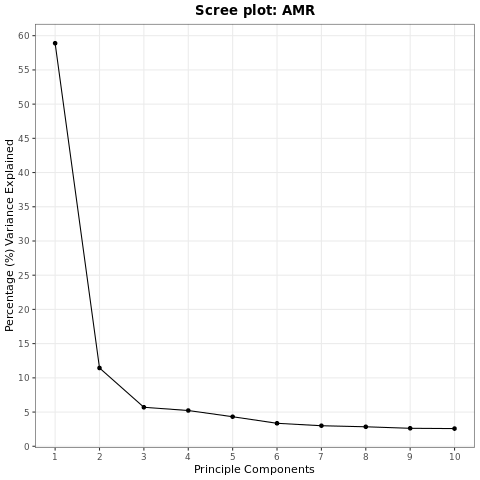

In [8]:
%%R

scree_aac <- plot_scree("AAC")
scree_afr <- plot_scree("AFR")
scree_aj  <- plot_scree("AJ")
scree_amr <- plot_scree("AMR")


scree_amr

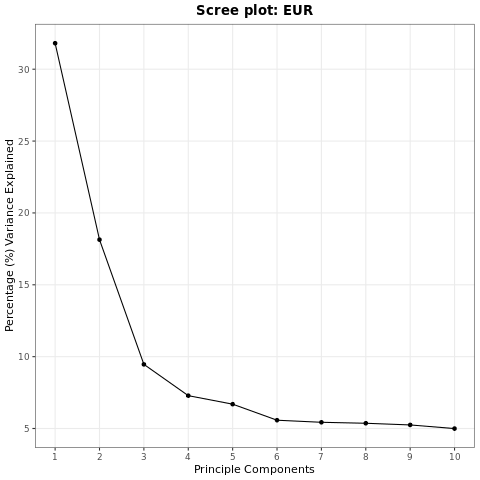

In [12]:
%%R

scree_cah <- plot_scree("CAH")
scree_cas <- plot_scree("CAS")
scree_eas <- plot_scree("EAS")
scree_eur <- plot_scree("EUR")

scree_eur

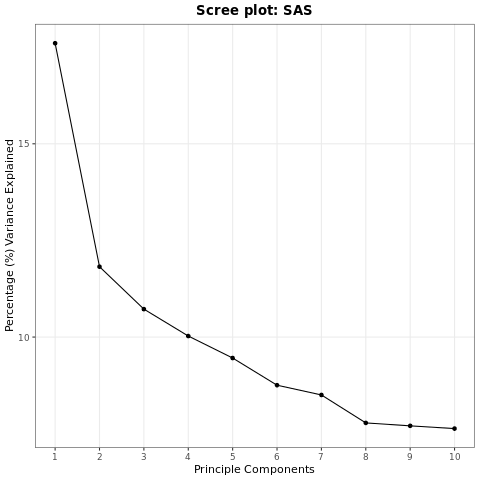

In [15]:
%%R

scree_fin <- plot_scree("FIN")
scree_mde <- plot_scree("MDE")
scree_sas <- plot_scree("SAS")

scree_sas

#### Run glm

##### By Sex and PCs

In [12]:
%%bash
WORK_DIR=/home/jupyter/A419V_release9
cd $WORK_DIR

run_glm() {
    local ancestry="$1"  # First argument: ancestry label
    local num_pcs="$2"   # Second argument: number of PCs to adjust

    BASE_DIR="/home/jupyter/A419V_release9"
    PHENO_FILE="${BASE_DIR}/${ancestry}/${ancestry}_covar.txt"
    OUT_FILE="${BASE_DIR}/${ancestry}/${ancestry}_a419v_adjusted"

    # Generate PC covariate names dynamically (e.g., PC1,PC2,...,PCn)
    PC_COVARS=$(seq -s, 1 "$num_pcs" | sed 's/[0-9]*/PC&/g')

    # Construct and run the PLINK2 command
    /home/jupyter/plink2 \
        --bfile ${BASE_DIR}/${ancestry}/${ancestry}_release9_remove_related_a419v \
        --glm no-x-sex firth-fallback cols=+a1freq,+a1freqcc,+a1count,+totallele,+a1countcc,+totallelecc,+err,+gcountcc \
        --pheno-name PHENO --covar-variance-standardize \
        --pheno "$PHENO_FILE" \
        --covar "$PHENO_FILE" \
        --covar-name SEX,"$PC_COVARS" \
        --ci 0.95 \
        --out "$OUT_FILE"
}



run_glm "CAH" 5
run_glm "CAS" 6
run_glm "EAS" 5
run_glm "EUR" 5

PLINK v2.0.0-a.6.9LM 64-bit Intel (29 Jan 2025)    cog-genomics.org/plink/2.0/
(C) 2005-2025 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/jupyter/A419V_release9/AAC/AAC_a419v_adjusted.log.
Options in effect:
  --bfile /home/jupyter/A419V_release9/AAC/AAC_release9_remove_related_a419v
  --ci 0.95
  --covar /home/jupyter/A419V_release9/AAC/AAC_covar.txt
  --covar-name SEX,PC1,PC2,PC3,PC4
  --covar-variance-standardize
  --glm no-x-sex firth-fallback cols=+a1freq,+a1freqcc,+a1count,+totallele,+a1countcc,+totallelecc,+err,+gcountcc
  --out /home/jupyter/A419V_release9/AAC/AAC_a419v_adjusted
  --pheno /home/jupyter/A419V_release9/AAC/AAC_covar.txt
  --pheno-name PHENO

Start time: Tue Apr 15 08:40:07 2025
3672 MiB RAM detected, ~1804 available; reserving 1740 MiB for main workspace.
Using 1 compute thread.
1207 samples (709 females, 498 males; 1207 founders) loaded from
/home/jupyter/A419V_release9/AAC/AAC_release9_remove_related_a419v.fam.
2 variants lo

  --pheno-name PHENO

Start time: Tue Apr 15 08:40:08 2025
3672 MiB RAM detected, ~1806 available; reserving 1742 MiB for main workspace.
Using 1 compute thread.
5646 samples (2151 females, 3495 males; 5646 founders) loaded from
/home/jupyter/A419V_release9/EAS/EAS_release9_remove_related_a419v.fam.
2 variants loaded from
/home/jupyter/A419V_release9/EAS/EAS_release9_remove_related_a419v.bim.
1 binary phenotype loaded (3192 cases, 2379 controls).
6 covariates loaded from /home/jupyter/A419V_release9/EAS/EAS_covar.txt.
--covar-variance-standardize: 6 covariates transformed.
Calculating allele frequencies... done.
--glm logistic-Firth hybrid regression on phenotype 'PHENO': done.
Results written to /home/jupyter/A419V_release9/EAS/EAS_a419v_adjusted.PHENO.glm.logistic.hybrid .
End time: Tue Apr 15 08:40:08 2025
PLINK v2.0.0-a.6.9LM 64-bit Intel (29 Jan 2025)    cog-genomics.org/plink/2.0/
(C) 2005-2025 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/jupy

phenotype 'PHENO'.


PLINK v2.0.0-a.6.9LM 64-bit Intel (29 Jan 2025)    cog-genomics.org/plink/2.0/
(C) 2005-2025 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/jupyter/A419V_release9/MDE/MDE_a419v_adjusted.log.
Options in effect:
  --bfile /home/jupyter/A419V_release9/MDE/MDE_release9_remove_related_a419v
  --ci 0.95
  --covar /home/jupyter/A419V_release9/MDE/MDE_covar.txt
  --covar-name SEX,PC1,PC2,PC3,PC4,PC5
  --covar-variance-standardize
  --glm no-x-sex firth-fallback cols=+a1freq,+a1freqcc,+a1count,+totallele,+a1countcc,+totallelecc,+err,+gcountcc
  --out /home/jupyter/A419V_release9/MDE/MDE_a419v_adjusted
  --pheno /home/jupyter/A419V_release9/MDE/MDE_covar.txt
  --pheno-name PHENO

Start time: Tue Apr 15 08:40:08 2025
3672 MiB RAM detected, ~1795 available; reserving 1731 MiB for main workspace.
Using 1 compute thread.
712 samples (274 females, 438 males; 712 founders) loaded from
/home/jupyter/A419V_release9/MDE/MDE_release9_remove_related_a419v.fam.
2 variants 

In [1]:
%%bash
WORK_DIR=/home/jupyter/A419V_release9
cd $WORK_DIR

run_glm() {

    local ancestry="$1"  # First argument: ancestry label
    local num_pcs="$2"   # Second argument: number of PCs to adjust

    BASE_DIR="/home/jupyter/A419V_release9"
    PHENO_FILE="${BASE_DIR}/${ancestry}/${ancestry}_covar.txt"
    OUT_FILE="${BASE_DIR}/${ancestry}/${ancestry}_a419v_adjusted"

    # Generate PC covariate names dynamically (e.g., PC1,PC2,...,PCn)
    PC_COVARS=$(seq -s, 1 "$num_pcs" | sed 's/[0-9]*/PC&/g')

    # Construct and run the PLINK2 command
    /home/jupyter/plink2 \
        --bfile ${BASE_DIR}/${ancestry}/${ancestry}_release9_remove_related_a419v \
        --glm \
        --pheno-name PHENO --covar-variance-standardize \
        --pheno "$PHENO_FILE" \
        --covar "$PHENO_FILE" \
        --covar-name SEX,"$PC_COVARS" \
        --ci 0.95 \
        --out "$OUT_FILE"
}


run_glm "CAH" 5
run_glm "CAS" 6
run_glm "EAS" 5
run_glm "EUR" 5

PLINK v2.0.0-a.6.9LM 64-bit Intel (29 Jan 2025)    cog-genomics.org/plink/2.0/
(C) 2005-2025 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/jupyter/A419V_release9/AAC/AAC_a419v_adjusted.log.
Options in effect:
  --bfile /home/jupyter/A419V_release9/AAC/AAC_release9_remove_related_a419v
  --ci 0.95
  --covar /home/jupyter/A419V_release9/AAC/AAC_covar.txt
  --covar-name SEX,PC1,PC2,PC3,PC4
  --covar-variance-standardize
  --glm
  --out /home/jupyter/A419V_release9/AAC/AAC_a419v_adjusted
  --pheno /home/jupyter/A419V_release9/AAC/AAC_covar.txt
  --pheno-name PHENO

Start time: Wed Apr  9 01:07:59 2025
3672 MiB RAM detected, ~2474 available; reserving 1836 MiB for main workspace.
Using 1 compute thread.
1207 samples (709 females, 498 males; 1207 founders) loaded from
/home/jupyter/A419V_release9/AAC/AAC_release9_remove_related_a419v.fam.
2 variants loaded from
/home/jupyter/A419V_release9/AAC/AAC_release9_remove_related_a419v.bim.
1 binary phenotype loade

--glm logistic-Firth hybrid regression on phenotype 'PHENO': done.
Results written to /home/jupyter/A419V_release9/EAS/EAS_a419v_adjusted.PHENO.glm.logistic.hybrid .
End time: Wed Apr  9 01:08:00 2025
PLINK v2.0.0-a.6.9LM 64-bit Intel (29 Jan 2025)    cog-genomics.org/plink/2.0/
(C) 2005-2025 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/jupyter/A419V_release9/EUR/EUR_a419v_adjusted.log.
Options in effect:
  --bfile /home/jupyter/A419V_release9/EUR/EUR_release9_remove_related_a419v
  --ci 0.95
  --covar /home/jupyter/A419V_release9/EUR/EUR_covar.txt
  --covar-name SEX,PC1,PC2,PC3,PC4,PC5
  --covar-variance-standardize
  --glm
  --out /home/jupyter/A419V_release9/EUR/EUR_a419v_adjusted
  --pheno /home/jupyter/A419V_release9/EUR/EUR_covar.txt
  --pheno-name PHENO

Start time: Wed Apr  9 01:08:00 2025
3672 MiB RAM detected, ~2470 available; reserving 1836 MiB for main workspace.
Using 1 compute thread.
34703 samples (15464 females, 19239 males; 34703 fo

phenotype 'PHENO'.


PLINK v2.0.0-a.6.9LM 64-bit Intel (29 Jan 2025)    cog-genomics.org/plink/2.0/
(C) 2005-2025 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/jupyter/A419V_release9/MDE/MDE_a419v_adjusted.log.
Options in effect:
  --bfile /home/jupyter/A419V_release9/MDE/MDE_release9_remove_related_a419v
  --ci 0.95
  --covar /home/jupyter/A419V_release9/MDE/MDE_covar.txt
  --covar-name SEX,PC1,PC2,PC3,PC4,PC5
  --covar-variance-standardize
  --glm
  --out /home/jupyter/A419V_release9/MDE/MDE_a419v_adjusted
  --pheno /home/jupyter/A419V_release9/MDE/MDE_covar.txt
  --pheno-name PHENO

Start time: Wed Apr  9 01:08:01 2025
3672 MiB RAM detected, ~2459 available; reserving 1836 MiB for main workspace.
Using 1 compute thread.
712 samples (274 females, 438 males; 712 founders) loaded from
/home/jupyter/A419V_release9/MDE/MDE_release9_remove_related_a419v.fam.
2 variants loaded from
/home/jupyter/A419V_release9/MDE/MDE_release9_remove_related_a419v.bim.
1 binary phenotype loa

In [13]:
lables = ['AAC', 'AJ', 'AMR', 'CAH', 'CAS', 'EAS', 'EUR', 'MDE', 'SAS']

df_results = pd.DataFrame()
for label in lables:
    
    glm = pd.read_csv(f"/home/jupyter/A419V_release9/{label}/{label}_a419v_adjusted.PHENO.glm.logistic.hybrid", sep = "\t")
    glm[["#CHROM", "POS", "ID", "REF", "ALT", "A1_FREQ", "CASE_NON_A1_CT", "CASE_HET_A1_CT", "CASE_HOM_A1_CT", "CTRL_NON_A1_CT", "CTRL_HET_A1_CT", "CTRL_HOM_A1_CT", "OR", "L95", "U95", "P"]]
    glm['label'] = f"{label}"
    df_results = pd.concat([df_results, glm], axis=0, ignore_index=True)

df_results

,#CHROM,POS,ID,REF,ALT,PROVISIONAL_REF?,A1,OMITTED,A1_CT,ALLELE_CT,A1_CASE_CT,A1_CTRL_CT,CASE_ALLELE_CT,CTRL_ALLELE_CT,CASE_NON_A1_CT,CASE_HET_A1_CT,CASE_HOM_A1_CT,CTRL_NON_A1_CT,CTRL_HET_A1_CT,CTRL_HOM_A1_CT,A1_FREQ,A1_CASE_FREQ,A1_CTRL_FREQ,FIRTH?,TEST,OBS_CT,OR,LOG(OR)_SE,L95,U95,Z_STAT,P,ERRCODE,label
0,12,40252984,Seq_rs34594498,G,A,Y,A,G,0,2324,0,0,676,1648,338,0,0,824,0,0,0.000000,0.000000,0.000000,N,ADD,1162,NaN,NaN,NaN,NaN,NaN,NaN,CONST_OMITTED_ALLELE,AAC
1,12,40252984,Seq_rs34594498,G,A,Y,A,G,0,2324,0,0,676,1648,338,0,0,824,0,0,0.000000,0.000000,0.000000,N,SEX,1162,NaN,NaN,NaN,NaN,NaN,NaN,CONST_OMITTED_ALLELE,AAC
2,12,40252984,Seq_rs34594498,G,A,Y,A,G,0,2324,0,0,676,1648,338,0,0,824,0,0,0.000000,0.000000,0.000000,N,PC1,1162,NaN,NaN,NaN,NaN,NaN,NaN,CONST_OMITTED_ALLELE,AAC
3,12,40252984,Seq_rs34594498,G,A,Y,A,G,0,2324,0,0,676,1648,338,0,0,824,0,0,0.000000,0.000000,0.000000,N,PC2,1162,NaN,NaN,NaN,NaN,NaN,NaN,CONST_OMITTED_ALLELE,AAC
4,12,40252984,Seq_rs34594498,G,A,Y,A,G,0,2324,0,0,676,1648,338,0,0,824,0,0,0.000000,0.000000,0.000000,N,PC3,1162,NaN,NaN,NaN,NaN,NaN,NaN,CONST_OMITTED_ALLELE,AAC
5,12,40252984,Seq_rs34594498,G,A,Y,A,G,0,2324,0,0,676,1648,338,0,0,824,0,0,0.000000,0.000000,0.000000,N,PC4,1162,NaN,NaN,NaN,NaN,NaN,NaN,CONST_OMITTED_ALLELE,AAC
6,12,40252984,exm994472,G,A,Y,A,G,0,2330,0,0,676,1654,338,0,0,827,0,0,0.000000,0.000000,0.000000,N,ADD,1165,NaN,NaN,NaN,NaN,NaN,NaN,CONST_OMITTED_ALLELE,AAC
7,12,40252984,exm994472,G,A,Y,A,G,0,2330,0,0,676,1654,338,0,0,827,0,0,0.000000,0.000000,0.000000,N,SEX,1165,NaN,NaN,NaN,NaN,NaN,NaN,CONST_OMITTED_ALLELE,AAC
8,12,40252984,exm994472,G,A,Y,A,G,0,2330,0,0,676,1654,338,0,0,827,0,0,0.000000,0.000000,0.000000,N,PC1,1165,NaN,NaN,NaN,NaN,NaN,NaN,CONST_OMITTED_ALLELE,AAC
9,12,40252984,exm994472,G,A,Y,A,G,0,2330,0,0,676,1654,338,0,0,827,0,0,0.000000,0.000000,0.000000,N,PC2,1165,NaN,NaN,NaN,NaN,NaN,NaN,CONST_OMITTED_ALLELE,AAC


##### Adding on results

##### By age, sex and PCs

In [14]:
%%bash
WORK_DIR=/home/jupyter/A419V_release9
cd $WORK_DIR

run_glm() {
    local ancestry="$1"  # First argument: ancestry label
    local num_pcs="$2"   # Second argument: number of PCs to adjust

    BASE_DIR="/home/jupyter/A419V_release9"
    PHENO_FILE="${BASE_DIR}/${ancestry}/${ancestry}_covar.txt"
    OUT_FILE="${BASE_DIR}/${ancestry}/${ancestry}_a419v_adjusted_withage"

    # Generate PC covariate names dynamically (e.g., PC1,PC2,...,PCn)
    PC_COVARS=$(seq -s, 1 "$num_pcs" | sed 's/[0-9]*/PC&/g')

    # Construct and run the PLINK2 command
    /home/jupyter/plink2 \
        --bfile ${BASE_DIR}/${ancestry}/${ancestry}_release9_remove_related_a419v \
        --glm no-x-sex firth-fallback cols=+a1freq,+a1freqcc,+a1count,+totallele,+a1countcc,+totallelecc,+err,+gcountcc \
        --pheno-name PHENO --covar-variance-standardize \
        --pheno "$PHENO_FILE" \
        --covar "$PHENO_FILE" \
        --covar-name SEX,AGE,"$PC_COVARS" \
        --ci 0.95 \
        --out "$OUT_FILE"
}

run_glm "CAH" 5
run_glm "CAS" 6
run_glm "EAS" 5
run_glm "EUR" 5

PLINK v2.0.0-a.6.9LM 64-bit Intel (29 Jan 2025)    cog-genomics.org/plink/2.0/
(C) 2005-2025 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/jupyter/A419V_release9/AAC/AAC_a419v_adjusted_withage.log.
Options in effect:
  --bfile /home/jupyter/A419V_release9/AAC/AAC_release9_remove_related_a419v
  --ci 0.95
  --covar /home/jupyter/A419V_release9/AAC/AAC_covar.txt
  --covar-name SEX,AGE,PC1,PC2,PC3,PC4
  --covar-variance-standardize
  --glm no-x-sex firth-fallback cols=+a1freq,+a1freqcc,+a1count,+totallele,+a1countcc,+totallelecc,+err,+gcountcc
  --out /home/jupyter/A419V_release9/AAC/AAC_a419v_adjusted_withage
  --pheno /home/jupyter/A419V_release9/AAC/AAC_covar.txt
  --pheno-name PHENO

Start time: Tue Apr 15 08:47:12 2025
3672 MiB RAM detected, ~1796 available; reserving 1732 MiB for main workspace.
Using 1 compute thread.
1207 samples (709 females, 498 males; 1207 founders) loaded from
/home/jupyter/A419V_release9/AAC/AAC_release9_remove_related_a419

  --out /home/jupyter/A419V_release9/EAS/EAS_a419v_adjusted_withage
  --pheno /home/jupyter/A419V_release9/EAS/EAS_covar.txt
  --pheno-name PHENO

Start time: Tue Apr 15 08:47:12 2025
3672 MiB RAM detected, ~1796 available; reserving 1732 MiB for main workspace.
Using 1 compute thread.
5646 samples (2151 females, 3495 males; 5646 founders) loaded from
/home/jupyter/A419V_release9/EAS/EAS_release9_remove_related_a419v.fam.
2 variants loaded from
/home/jupyter/A419V_release9/EAS/EAS_release9_remove_related_a419v.bim.
1 binary phenotype loaded (3192 cases, 2379 controls).
7 covariates loaded from /home/jupyter/A419V_release9/EAS/EAS_covar.txt.
--covar-variance-standardize: 7 covariates transformed.
Calculating allele frequencies... done.
--glm logistic-Firth hybrid regression on phenotype 'PHENO': done.
Results written to /home/jupyter/A419V_release9/EAS/EAS_a419v_adjusted_withage.PHENO.glm.logistic.hybrid .
End time: Tue Apr 15 08:47:12 2025
PLINK v2.0.0-a.6.9LM 64-bit Intel (29 Jan 2025

phenotype 'PHENO'.


PLINK v2.0.0-a.6.9LM 64-bit Intel (29 Jan 2025)    cog-genomics.org/plink/2.0/
(C) 2005-2025 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/jupyter/A419V_release9/MDE/MDE_a419v_adjusted_withage.log.
Options in effect:
  --bfile /home/jupyter/A419V_release9/MDE/MDE_release9_remove_related_a419v
  --ci 0.95
  --covar /home/jupyter/A419V_release9/MDE/MDE_covar.txt
  --covar-name SEX,AGE,PC1,PC2,PC3,PC4,PC5
  --covar-variance-standardize
  --glm no-x-sex firth-fallback cols=+a1freq,+a1freqcc,+a1count,+totallele,+a1countcc,+totallelecc,+err,+gcountcc
  --out /home/jupyter/A419V_release9/MDE/MDE_a419v_adjusted_withage
  --pheno /home/jupyter/A419V_release9/MDE/MDE_covar.txt
  --pheno-name PHENO

Start time: Tue Apr 15 08:47:13 2025
3672 MiB RAM detected, ~1792 available; reserving 1728 MiB for main workspace.
Using 1 compute thread.
712 samples (274 females, 438 males; 712 founders) loaded from
/home/jupyter/A419V_release9/MDE/MDE_release9_remove_related_a4

In [15]:
lables = ['AAC', 'AJ', 'AMR', 'CAH', 'CAS', 'EAS', 'EUR', 'FIN', 'MDE', 'SAS']

df_results = pd.DataFrame()
for label in lables:
    
    glm = pd.read_csv(f"/home/jupyter/A419V_release9/{label}/{label}_a419v_adjusted_withage.PHENO.glm.logistic.hybrid", sep = "\t")
    glm[["#CHROM", "POS", "ID", "REF", "ALT", "A1_FREQ", "CASE_NON_A1_CT", "CASE_HET_A1_CT", "CASE_HOM_A1_CT", "CTRL_NON_A1_CT", "CTRL_HET_A1_CT", "CTRL_HOM_A1_CT", "OR", "L95", "U95", "P"]]
    glm['label'] = f"{label}"
    df_results = pd.concat([df_results, glm], axis=0, ignore_index=True)

df_results

,#CHROM,POS,ID,REF,ALT,PROVISIONAL_REF?,A1,OMITTED,A1_CT,ALLELE_CT,A1_CASE_CT,A1_CTRL_CT,CASE_ALLELE_CT,CTRL_ALLELE_CT,CASE_NON_A1_CT,CASE_HET_A1_CT,CASE_HOM_A1_CT,CTRL_NON_A1_CT,CTRL_HET_A1_CT,CTRL_HOM_A1_CT,A1_FREQ,A1_CASE_FREQ,A1_CTRL_FREQ,FIRTH?,TEST,OBS_CT,OR,LOG(OR)_SE,L95,U95,Z_STAT,P,ERRCODE,label
0,12,40252984,Seq_rs34594498,G,A,Y,A,G,0,2324,0,0,676,1648,338,0,0,824,0,0,0.000000,0.000000,0.000000,N,ADD,1162,NaN,NaN,NaN,NaN,NaN,NaN,CONST_OMITTED_ALLELE,AAC
1,12,40252984,Seq_rs34594498,G,A,Y,A,G,0,2324,0,0,676,1648,338,0,0,824,0,0,0.000000,0.000000,0.000000,N,SEX,1162,NaN,NaN,NaN,NaN,NaN,NaN,CONST_OMITTED_ALLELE,AAC
2,12,40252984,Seq_rs34594498,G,A,Y,A,G,0,2324,0,0,676,1648,338,0,0,824,0,0,0.000000,0.000000,0.000000,N,AGE,1162,NaN,NaN,NaN,NaN,NaN,NaN,CONST_OMITTED_ALLELE,AAC
3,12,40252984,Seq_rs34594498,G,A,Y,A,G,0,2324,0,0,676,1648,338,0,0,824,0,0,0.000000,0.000000,0.000000,N,PC1,1162,NaN,NaN,NaN,NaN,NaN,NaN,CONST_OMITTED_ALLELE,AAC
4,12,40252984,Seq_rs34594498,G,A,Y,A,G,0,2324,0,0,676,1648,338,0,0,824,0,0,0.000000,0.000000,0.000000,N,PC2,1162,NaN,NaN,NaN,NaN,NaN,NaN,CONST_OMITTED_ALLELE,AAC
5,12,40252984,Seq_rs34594498,G,A,Y,A,G,0,2324,0,0,676,1648,338,0,0,824,0,0,0.000000,0.000000,0.000000,N,PC3,1162,NaN,NaN,NaN,NaN,NaN,NaN,CONST_OMITTED_ALLELE,AAC
6,12,40252984,Seq_rs34594498,G,A,Y,A,G,0,2324,0,0,676,1648,338,0,0,824,0,0,0.000000,0.000000,0.000000,N,PC4,1162,NaN,NaN,NaN,NaN,NaN,NaN,CONST_OMITTED_ALLELE,AAC
7,12,40252984,exm994472,G,A,Y,A,G,0,2330,0,0,676,1654,338,0,0,827,0,0,0.000000,0.000000,0.000000,N,ADD,1165,NaN,NaN,NaN,NaN,NaN,NaN,CONST_OMITTED_ALLELE,AAC
8,12,40252984,exm994472,G,A,Y,A,G,0,2330,0,0,676,1654,338,0,0,827,0,0,0.000000,0.000000,0.000000,N,SEX,1165,NaN,NaN,NaN,NaN,NaN,NaN,CONST_OMITTED_ALLELE,AAC
9,12,40252984,exm994472,G,A,Y,A,G,0,2330,0,0,676,1654,338,0,0,827,0,0,0.000000,0.000000,0.000000,N,AGE,1165,NaN,NaN,NaN,NaN,NaN,NaN,CONST_OMITTED_ALLELE,AAC


##### Adding info to GLM

In [63]:
labels = ['CAH', 'EAS', 'EUR']
variant = "exm994472_A"
results = []  

for label in labels:
    
    recode = pd.read_csv(f"/home/jupyter/A419V_release9/{label}/{label}_release9_remove_related_a419v.raw", 
                             delim_whitespace=True)

    all_cases = recode[recode['PHENOTYPE'] == 2]
    all_controls = recode[recode['PHENOTYPE'] == 1]
    total_cases = all_cases.shape[0]
    total_controls = all_controls.shape[0]
    
    covar = pd.read_csv(f"/home/jupyter/A419V_release9/{label}/{label}_covar.txt", sep = "\t")
    covar_red = covar[["IID", "AGE"]]
    merge = pd.merge(recode, covar_red, on = "IID", how = "left")
    merge = merge[~merge["AGE"].isna()]
    
    cases_data = merge[merge['PHENOTYPE'] == 2]
    controls_data = merge[merge['PHENOTYPE'] == 1]
    
    # Cases
    hom_cases = (cases_data[variant] == 2).sum()
    het_cases = (cases_data[variant] == 1).sum()
    hom_ref_cases = (cases_data[variant] == 0).sum()
    missing_cases = total_cases - (hom_cases + het_cases + hom_ref_cases)
    freq_cases = (2 * hom_cases + het_cases) / (2 * (total_cases - missing_cases)) if (total_cases - missing_cases) > 0 else None

    # Controls
    hom_controls = (controls_data[variant] == 2).sum()
    het_controls = (controls_data[variant] == 1).sum()
    hom_ref_controls = (controls_data[variant] == 0).sum()
    missing_controls = total_controls - (hom_controls + het_controls + hom_ref_controls)
    freq_controls = (2 * hom_controls + het_controls) / (2 * (total_controls - missing_controls)) if (total_controls - missing_controls) > 0 else None
    
    # Collect results
    results.append({
        'Ancestry': label,
        'Variant': variant,
        'Hom Cases': hom_cases,
        'Het Cases': het_cases,
        'Hom Ref Cases': hom_ref_cases,
        'Missing Cases': missing_cases,
        'Total Cases': cases_data.shape[0],
        'Carrier Freq in Cases': freq_cases,
        'Hom Controls': hom_controls,
        'Het Controls': het_controls,
        'Hom Ref Controls': hom_ref_controls,
        'Missing Controls': missing_controls,
        'Total Controls': controls_data.shape[0],
        'Carrier Freq in Controls': freq_controls
    })

# Convert to DataFrame
df_results = pd.DataFrame(results)
df_results

,Ancestry,Variant,Hom Cases,Het Cases,Hom Ref Cases,Missing Cases,Total Cases,Carrier Freq in Cases,Hom Controls,Het Controls,Hom Ref Controls,Missing Controls,Total Controls,Carrier Freq in Controls
0,CAH,exm994472_A,0,2,554,88,556,0.001799,0,0,299,11,299,0.000000
1,EAS,exm994472_A,1,58,2551,582,2612,0.011494,1,13,1292,1073,1307,0.005743
2,EUR,exm994472_A,1,12,11884,3435,11906,0.000588,0,1,3176,2315,3179,0.000157


In [62]:
labels = ['AJ', 'CAS']
variant = "Seq_rs34594498_A"
results = []  

for label in labels:
    
    recode = pd.read_csv(f"/home/jupyter/A419V_release9/{label}/{label}_release9_remove_related_a419v.raw", 
                             delim_whitespace=True)

    all_cases = recode[recode['PHENOTYPE'] == 2]
    all_controls = recode[recode['PHENOTYPE'] == 1]
    total_cases = all_cases.shape[0]
    total_controls = all_controls.shape[0]
    
    covar = pd.read_csv(f"/home/jupyter/A419V_release9/{label}/{label}_covar.txt", sep = "\t")
    covar_red = covar[["IID", "AGE"]]
    merge = pd.merge(recode, covar_red, on = "IID", how = "left")
    merge = merge[~merge["AGE"].isna()]
    
    cases_data = merge[merge['PHENOTYPE'] == 2]
    controls_data = merge[merge['PHENOTYPE'] == 1]
    
    # Cases
    hom_cases = (cases_data[variant] == 2).sum()
    het_cases = (cases_data[variant] == 1).sum()
    hom_ref_cases = (cases_data[variant] == 0).sum()
    missing_cases = total_cases - (hom_cases + het_cases + hom_ref_cases)
    freq_cases = (2 * hom_cases + het_cases) / (2 * (total_cases - missing_cases)) if (total_cases - missing_cases) > 0 else None

    # Controls
    hom_controls = (controls_data[variant] == 2).sum()
    het_controls = (controls_data[variant] == 1).sum()
    hom_ref_controls = (controls_data[variant] == 0).sum()
    missing_controls = total_controls - (hom_controls + het_controls + hom_ref_controls)
    freq_controls = (2 * hom_controls + het_controls) / (2 * (total_controls - missing_controls)) if (total_controls - missing_controls) > 0 else None
    
    # Collect results
    results.append({
        'Ancestry': label,
        'Variant': variant,
        'Hom Cases': hom_cases,
        'Het Cases': het_cases,
        'Hom Ref Cases': hom_ref_cases,
        'Missing Cases': missing_cases,
        'Total Cases': cases_data.shape[0],
        'Carrier Freq in Cases': freq_cases,
        'Hom Controls': hom_controls,
        'Het Controls': het_controls,
        'Hom Ref Controls': hom_ref_controls,
        'Missing Controls': missing_controls,
        'Total Controls': controls_data.shape[0],
        'Carrier Freq in Controls': freq_controls
    })

# Convert to DataFrame
df_results = pd.DataFrame(results)
df_results

,Ancestry,Variant,Hom Cases,Het Cases,Hom Ref Cases,Missing Cases,Total Cases,Carrier Freq in Cases,Hom Controls,Het Controls,Hom Ref Controls,Missing Controls,Total Controls,Carrier Freq in Controls
0,AJ,Seq_rs34594498_A,0,1,1613,95,1617,0.00031,0,0,627,197,627,0.000000
1,CAS,Seq_rs34594498_A,0,10,518,133,528,0.00947,0,4,235,90,239,0.008368


## EUR focus

### PCA

In [41]:
%%bash

WORK_DIR=/home/jupyter/A419V_release9/EUR
cd $WORK_DIR

/home/jupyter/plink1.9 \
--bfile EUR_release9_remove_related_a419v \
--recode A \
--out EUR_release9_remove_related_a419v

PLINK v1.90b6.9 64-bit (4 Mar 2019)            www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to EUR_release9_remove_related_a419v.log.
Options in effect:
  --bfile EUR_release9_remove_related_a419v
  --out EUR_release9_remove_related_a419v
  --recode A

52216 MB RAM detected; reserving 26108 MB for main workspace.
2 variants loaded from .bim file.
34703 people (19239 males, 15464 females) loaded from .fam.
20824 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 34703 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.99915.
2 variants and 34703 people pass filters and QC.
Among remaining phenotypes, 15332 are cases an

In [34]:
%%R

WD  <- "/home/jupyter/A419V_release9/"
anc <- "EUR"

raw <- read.delim(paste0(WD, anc, "/", anc, "_release9_remove_related_a419v.raw"), sep = " ")
raw <- raw %>% mutate(chr12_40252984_G_A_A = exm994472_A) %>% filter(PHENOTYPE != -9) %>%
       select(FID, IID, SEX, PHENOTYPE, chr12_40252984_G_A_A)

cov    <- read.csv(paste0(WD, "master_key_release9_final.csv")) %>% mutate(IID = GP2ID) %>% select(IID, region_for_qc)

merged <- left_join(raw, cov, by = "IID")

eigenvec <- read.delim(paste0(WD, anc, "/", anc, "_release9.eigenvec"), sep = "\t")

merged_eigen <- left_join(merged, eigenvec, by = "IID")

write.csv(merged_eigen, file = paste0(WD, anc, "/", anc, "_cov_eigen.csv"))

In [35]:
shell_do(f"gsutil -u {BILLING_PROJECT_ID} -m cp /home/jupyter/A419V_release9/EUR/EUR_cov_eigen.csv {WORKSPACE_BUCKET}/A419V_analysis/local_ancestry/")

Executing: gsutil -u terra-8cb3be5c -m cp /home/jupyter/A419V_release9/EUR/EUR_cov_eigen.csv gs://fc-e8a73e41-545c-42b1-8720-970cf953ba35/A419V_analysis/local_ancestry/


Copying file:///home/jupyter/A419V_release9/EUR/EUR_cov_eigen.csv [Content-Type=text/csv]...
/ [1/1 files][  3.1 MiB/  3.1 MiB] 100% Done                                    
Operation completed over 1 objects/3.1 MiB.                                      


### Admixture

In [6]:
shell_do(f"gsutil -u {BILLING_PROJECT_ID} -m cp Copying gs://gp2tier2/release9_18122024/meta_data/admixture/GP2_release9_labeled_admixture.txt /home/jupyter/A419V_release9/")

Executing: gsutil -u terra-8cb3be5c -m cp Copying gs://gp2tier2/release9_18122024/meta_data/admixture/GP2_release9_labeled_admixture.txt /home/jupyter/A419V_release9/


CommandException: No URLs matched: Copying
Copying gs://gp2tier2/release9_18122024/meta_data/admixture/GP2_release9_labeled_admixture.txt...
/ [1/1 files][ 10.8 MiB/ 10.8 MiB] 100% Done                                    
Operation completed over 1 objects/10.8 MiB.                                     
CommandException: 1 file/object could not be transferred.


In [22]:
WORK_DIR="/home/jupyter/A419V_release9/"
label = "EUR"
admix = pd.read_csv(f"{WORK_DIR}/GP2_release9_labeled_admixture.txt", sep = "\t")
raw = pd.read_csv(f"{WORK_DIR}/{label}/{label}_release9_remove_related_a419v.raw", delim_whitespace = True)
raw.rename(columns = {"exm994472_A" : "chr12_40252984_G_A_A"}, inplace = True)
raw_red = raw[["IID", "PHENOTYPE", "chr12_40252984_G_A_A"]]

admix_eur = pd.merge(admix, raw_red, on = "IID", how = "right")


cov = pd.read_csv("/home/jupyter/A419V_release9/master_key_release9_final.csv")
cov.rename(columns = {"GP2ID":"IID"}, inplace = True)
cov_red = cov[["IID", "region_for_qc"]]

admix_eur_cov = pd.merge(admix_eur, cov_red, on = "IID", how = "left")

admix_eur_cov.to_csv(f"{WORK_DIR}/EUR/EUR_admixture.txt", sep = "\t", header = True, index = False)

In [23]:
shell_do(f"gsutil -u {BILLING_PROJECT_ID} -m cp /home/jupyter/A419V_release9/EUR/EUR_admixture.txt {WORKSPACE_BUCKET}/A419V_analysis/local_ancestry/")

Executing: gsutil -u terra-8cb3be5c -m cp /home/jupyter/A419V_release9/EUR/EUR_admixture.txt gs://fc-e8a73e41-545c-42b1-8720-970cf953ba35/A419V_analysis/local_ancestry/


Copying file:///home/jupyter/A419V_release9/EUR/EUR_admixture.txt [Content-Type=text/plain]...
/ [1/1 files][  7.1 MiB/  7.1 MiB] 100% Done                                    
Operation completed over 1 objects/7.1 MiB.                                      


### GLM after remove highly admix samples

In [34]:
WORK_DIR="/home/jupyter/A419V_release9/"
label = "EUR"
admix = pd.read_csv(f"{WORK_DIR}/GP2_release9_labeled_admixture.txt", sep = "\t")
raw = pd.read_csv(f"{WORK_DIR}/{label}/{label}_release9_remove_related_a419v.raw", delim_whitespace = True)
raw.rename(columns = {"exm994472_A" : "chr12_40252984_G_A_A"}, inplace = True)
raw_red = raw[["IID", "PHENOTYPE", "chr12_40252984_G_A_A"]]

admix_eur = pd.merge(admix, raw_red, on = "IID", how = "right")

admix_eur[admix_eur["EUR"] < 0.6][["IID"]].to_csv(f"/home/jupyter/A419V_release9/EUR/EUR_admixed.txt", sep = "\t", index = False, header = False)

In [38]:
%%bash
WORK_DIR=/home/jupyter/A419V_release9
cd $WORK_DIR

wc -l EUR/EUR_admixed.txt

7257 EUR/EUR_admixed.txt


In [35]:
%%bash
WORK_DIR=/home/jupyter/A419V_release9
cd $WORK_DIR

ancestry="EUR"
/home/jupyter/plink2 \
--bfile ${ancestry}/${ancestry}_release9_remove_related_a419v \
--remove ${ancestry}/${ancestry}_admixed.txt \
--make-bed \
--out ${ancestry}/${ancestry}_release9_remove_related_a419v_rmadmixed

PLINK v2.0.0-a.6.9LM 64-bit Intel (29 Jan 2025)    cog-genomics.org/plink/2.0/
(C) 2005-2025 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to EUR/EUR_release9_remove_related_a419v_rmadmixed.log.
Options in effect:
  --bfile EUR/EUR_release9_remove_related_a419v
  --make-bed
  --out EUR/EUR_release9_remove_related_a419v_rmadmixed
  --remove EUR/EUR_admixed.txt

Start time: Tue May  6 10:48:23 2025
52216 MiB RAM detected, ~50005 available; reserving 26108 MiB for main
workspace.
Using up to 8 compute threads.
34703 samples (15464 females, 19239 males; 34703 founders) loaded from
EUR/EUR_release9_remove_related_a419v.fam.
2 variants loaded from EUR/EUR_release9_remove_related_a419v.bim.
1 binary phenotype loaded (15332 cases, 5492 controls).
--remove: 27446 samples remaining.
27446 samples (12176 females, 15270 males; 27446 founders) remaining after main
filters.
11559 cases and 4246 controls remaining after main filters.
Writing EUR/EUR_release9_remove_related_

In [39]:
%%bash
WORK_DIR=/home/jupyter/A419V_release9
cd $WORK_DIR

run_glm() {
    local ancestry="$1"  # First argument: ancestry label
    local num_pcs="$2"   # Second argument: number of PCs to adjust

    BASE_DIR="/home/jupyter/A419V_release9"
    PHENO_FILE="${BASE_DIR}/${ancestry}/${ancestry}_covar.txt"
    OUT_FILE="${BASE_DIR}/${ancestry}/${ancestry}_a419v_adjusted_withage_rmadmixed"

    # Generate PC covariate names dynamically (e.g., PC1,PC2,...,PCn)
    PC_COVARS=$(seq -s, 1 "$num_pcs" | sed 's/[0-9]*/PC&/g')

    # Construct and run the PLINK2 command
    /home/jupyter/plink2 \
        --bfile ${BASE_DIR}/${ancestry}/${ancestry}_release9_remove_related_a419v_rmadmixed \
        --glm no-x-sex firth-fallback cols=+a1freq,+a1freqcc,+a1count,+totallele,+a1countcc,+totallelecc,+err,+gcountcc \
        --pheno-name PHENO --covar-variance-standardize \
        --pheno "$PHENO_FILE" \
        --covar "$PHENO_FILE" \
        --covar-name SEX,AGE,"$PC_COVARS" \
        --ci 0.95 \
        --out "$OUT_FILE"
}

run_glm "EUR" 5

PLINK v2.0.0-a.6.9LM 64-bit Intel (29 Jan 2025)    cog-genomics.org/plink/2.0/
(C) 2005-2025 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/jupyter/A419V_release9/EUR/EUR_a419v_adjusted_withage_rmadmixed.log.
Options in effect:
  --bfile /home/jupyter/A419V_release9/EUR/EUR_release9_remove_related_a419v_rmadmixed
  --ci 0.95
  --covar /home/jupyter/A419V_release9/EUR/EUR_covar.txt
  --covar-name SEX,AGE,PC1,PC2,PC3,PC4,PC5
  --covar-variance-standardize
  --glm no-x-sex firth-fallback cols=+a1freq,+a1freqcc,+a1count,+totallele,+a1countcc,+totallelecc,+err,+gcountcc
  --out /home/jupyter/A419V_release9/EUR/EUR_a419v_adjusted_withage_rmadmixed
  --pheno /home/jupyter/A419V_release9/EUR/EUR_covar.txt
  --pheno-name PHENO

Start time: Tue May  6 10:49:11 2025
52216 MiB RAM detected, ~50025 available; reserving 26108 MiB for main
workspace.
Using up to 8 compute threads.
27446 samples (12176 females, 15270 males; 27446 founders) loaded from
/home/jupyter/A

In [40]:
%%bash
WORK_DIR=/home/jupyter/A419V_release9
cd $WORK_DIR

ancestry="EUR"
cat ${ancestry}/${ancestry}_a419v_adjusted_withage_rmadmixed.PHENO.glm.logistic.hybrid

#CHROM	POS	ID	REF	ALT	PROVISIONAL_REF?	A1	OMITTED	A1_CT	ALLELE_CT	A1_CASE_CT	A1_CTRL_CT	CASE_ALLELE_CT	CTRL_ALLELE_CT	CASE_NON_A1_CT	CASE_HET_A1_CT	CASE_HOM_A1_CT	CTRL_NON_A1_CT	CTRL_HET_A1_CT	CTRL_HOM_A1_CT	A1_FREQ	A1_CASE_FREQ	A1_CTRL_FREQ	FIRTH?	TEST	OBS_CT	OR	LOG(OR)_SE	L95	U95	Z_STAT	P	ERRCODE
12	40252984	Seq_rs34594498	G	A	Y	A	G	6	31584	6	0	23102	8482	11545	6	0	4241	0	0	0.00018997	0.000259718	0	Y	ADD	15792	4.94331	1.47379	0.275121	88.8202	1.0843	0.278231	.
12	40252984	Seq_rs34594498	G	A	Y	A	G	6	31584	6	0	23102	8482	11545	6	0	4241	0	0	0.00018997	0.000259718	0	Y	SEX	15792	0.847975	0.0187486	0.81738	0.879715	-8.79554	1.42359e-18	.
12	40252984	Seq_rs34594498	G	A	Y	A	G	6	31584	6	0	23102	8482	11545	6	0	4241	0	0	0.00018997	0.000259718	0	Y	AGE	15792	1.61734	0.0178637	1.5617	1.67497	26.914	1.50453e-159	.
12	40252984	Seq_rs34594498	G	A	Y	A	G	6	31584	6	0	23102	8482	11545	6	0	4241	0	0	0.00018997	0.000259718	0	Y	PC1	15792	1.06562	0.0188802	1.02691	1.10579	3.3665	0.000761298	.
12	40252984	Seq_

### CAS Admixture

In [8]:
WORK_DIR="/home/jupyter/A419V_release9/"
admix = pd.read_csv(f"{WORK_DIR}/GP2_release9_labeled_admixture.txt", sep = "\t")
raw = pd.read_csv(f"{WORK_DIR}/CAS/CAS_release9_extracted_merged.raw", delim_whitespace = True)
raw_red = raw[["IID", "PHENOTYPE", "chr12_40252984_G_A_A"]]

admix_cas = pd.merge(admix, raw_red, on = "IID", how = "right")


cov = pd.read_csv("/home/jupyter/A419V_release9/master_key_release9_final.csv")
cov.rename(columns = {"GP2ID":"IID"}, inplace = True)
cov_red = cov[["IID", "region_for_qc"]]

admix_cas_cov = pd.merge(admix_cas, cov_red, on = "IID", how = "left")

admix_cas_cov.to_csv(f"{WORK_DIR}/CAS/CAS_admixture.txt", sep = "\t", header = True, index = False)

In [12]:
shell_do(f"gsutil -u {BILLING_PROJECT_ID} -m cp /home/jupyter/A419V_release9/CAS/CAS_admixture.txt {WORKSPACE_BUCKET}/A419V_analysis/local_ancestry/")

Executing: gsutil -u terra-8cb3be5c -m cp /home/jupyter/A419V_release9/CAS/CAS_admixture.txt gs://fc-e8a73e41-545c-42b1-8720-970cf953ba35/A419V_analysis/local_ancestry/


Copying file:///home/jupyter/A419V_release9/CAS/CAS_admixture.txt [Content-Type=text/plain]...
/ [1/1 files][137.7 KiB/137.7 KiB] 100% Done                                    
Operation completed over 1 objects/137.7 KiB.                                    


## EAS focus

In [7]:
%%bash

WORK_DIR=/home/jupyter/A419V_release9/EAS
cd $WORK_DIR

/home/jupyter/plink1.9 \
--bfile EAS_release9_remove_related_a419v \
--recode A \
--out EAS_release9_remove_related_a419v

PLINK v1.90b6.9 64-bit (4 Mar 2019)            www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to EAS_release9_remove_related_a419v.log.
Options in effect:
  --bfile EAS_release9_remove_related_a419v
  --out EAS_release9_remove_related_a419v
  --recode A

52216 MB RAM detected; reserving 26108 MB for main workspace.
2 variants loaded from .bim file.
5646 people (3495 males, 2151 females) loaded from .fam.
5571 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 5646 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.998229.
2 variants and 5646 people pass filters and QC.
Among remaining phenotypes, 3192 are cases and 2379

### PCA

In [36]:
%%R

WD  <- "/home/jupyter/A419V_release9/"
anc <- "EAS"

raw <- read.delim(paste0(WD, anc, "/", anc, "_release9_remove_related_a419v.raw"), sep = " ")
raw <- raw %>% mutate(chr12_40252984_G_A_A = exm994472_A) %>% filter(PHENOTYPE != -9) %>%
       select(FID, IID, SEX, PHENOTYPE, chr12_40252984_G_A_A)

cov    <- read.csv(paste0(WD, "master_key_release9_final.csv")) %>% mutate(IID = GP2ID) %>% select(IID, region_for_qc)

merged <- left_join(raw, cov, by = "IID")

eigenvec <- read.delim(paste0(WD, anc, "/", anc, "_release9.eigenvec"), sep = "\t")

merged_eigen <- left_join(merged, eigenvec, by = "IID")

write.csv(merged_eigen, file = paste0(WD, anc, "/", anc, "_cov_eigen.csv"))

In [37]:
shell_do(f"gsutil -u {BILLING_PROJECT_ID} -m cp /home/jupyter/A419V_release9/EAS/EAS_cov_eigen.csv {WORKSPACE_BUCKET}/A419V_analysis/local_ancestry/")

Executing: gsutil -u terra-8cb3be5c -m cp /home/jupyter/A419V_release9/EAS/EAS_cov_eigen.csv gs://fc-e8a73e41-545c-42b1-8720-970cf953ba35/A419V_analysis/local_ancestry/


Copying file:///home/jupyter/A419V_release9/EAS/EAS_cov_eigen.csv [Content-Type=text/csv]...
/ [1/1 files][824.6 KiB/824.6 KiB] 100% Done                                    
Operation completed over 1 objects/824.6 KiB.                                    


### Admixture

In [12]:
raw = pd.read_csv(f"{WORK_DIR}/{label}/{label}_release9_remove_related_a419v.raw", delim_whitespace = True)
raw.rename(columns = {"exm994472_A" : "chr12_40252984_G_A_A"}, inplace = True)

In [13]:
WORK_DIR="/home/jupyter/A419V_release9/"
label="EAS"

admix = pd.read_csv(f"{WORK_DIR}/GP2_release9_labeled_admixture.txt", sep = "\t")
raw = pd.read_csv(f"{WORK_DIR}/{label}/{label}_release9_remove_related_a419v.raw", delim_whitespace = True)
raw.rename(columns = {"exm994472_A" : "chr12_40252984_G_A_A"}, inplace = True)
raw_red = raw[["IID", "PHENOTYPE", "chr12_40252984_G_A_A"]]

admix_merge = pd.merge(admix, raw_red, on = "IID", how = "right")

cov = pd.read_csv("/home/jupyter/A419V_release9/master_key_release9_final.csv")
cov.rename(columns = {"GP2ID":"IID"}, inplace = True)
cov_red = cov[["IID", "region_for_qc"]]

admix_merge_cov = pd.merge(admix_merge, cov_red, on = "IID", how = "left")

admix_merge_cov.to_csv(f"{WORK_DIR}/{label}/{label}_admixture.txt", sep = "\t", header = True, index = False)

In [14]:
shell_do(f"gsutil -u {BILLING_PROJECT_ID} -m cp /home/jupyter/A419V_release9/EAS/EAS_admixture.txt {WORKSPACE_BUCKET}/A419V_analysis/local_ancestry/")

Executing: gsutil -u terra-8cb3be5c -m cp /home/jupyter/A419V_release9/EAS/EAS_admixture.txt gs://fc-e8a73e41-545c-42b1-8720-970cf953ba35/A419V_analysis/local_ancestry/


Copying file:///home/jupyter/A419V_release9/EAS/EAS_admixture.txt [Content-Type=text/plain]...
/ [1/1 files][  1.2 MiB/  1.2 MiB] 100% Done                                    
Operation completed over 1 objects/1.2 MiB.                                      
